In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
import scipy.stats as stats
from netCDF4 import Dataset
import wrf
import sys
sys.path.append('../')
from pydicts.obsdict import get_FINO_obs
from mmctools.mmctools.plotting import TaylorDiagram
from mmctools.mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind, w_s, T_d
from mmctools.mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
from pydicts.baybreezedict import DetectBayBreeze
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import matplotlib.patches as patches
from string import ascii_lowercase

In [3]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


# Load the case dictionary file specifying case names, domains, colors, and markers

In [4]:
from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Get Obs

In [5]:
read_in_obs = True

In [6]:
if read_in_obs:
    obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
    awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
    asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
    apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

In [7]:
near_shore_stations  = []
inland_station_names = []
for stn in awos_ds.get_index('station'):
    if awos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if awos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in asos_ds.get_index('station'):
    if asos_ds.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if asos_ds.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)
for stn in apg_ds.get_index('station'):
    near_shore_stations.append(stn)

near_shore_stations = np.unique(near_shore_stations)
inland_station_names = np.unique(inland_station_names)

# Get WRF towers

### To get towers interpolated to obs levels:

In [8]:
ref_stn = 'IAD'

In [9]:
wrf_twrs = {}
for cc,case in enumerate(cases):
    dom = case_dom[cc]
    case_str = '{}_{}'.format(case,'d0{}'.format(dom))
    if dom == 3:
        dt = 9.0
    elif dom == 4:
        dt = 3.0
    else:
        print('Add logic for domain {}'.format(dom))
    print('Starting {} d0{}: time step = {}'.format(case_str,dom,dt))
    

    case_dir = '{}{}/'.format(wrf_dir,case)
    twr_path = '{}{}_d0{}_towers.nc'.format(case_dir,case,dom)    
    if path.exists(twr_path):
        print('loading in full dataset!')
        wrf_twrs[case_str] = xr.open_dataset(twr_path)
    else:
        wrf_twrs[case_str] = tsout_seriesReader(case_dir,restarts,wrf_start,'d0{}'.format(dom),structure='unordered',
                                            select_tower=np.append(near_shore_stations,ref_stn),time_step=dt,
                                            #select_tower=near_shore_stations[:2],time_step=dt,
                                            heights=[10.0],height_var='ph')
        wrf_twrs[case_str]['temp'] = theta_to_T(wrf_twrs[case_str].theta,wrf_twrs[case_str].pr/100.0)-273.15
        wrf_twrs[case_str]['wspd10'],wrf_twrs[case_str]['wdir10'] = calc_wind(wrf_twrs[case_str],u='u10',v='v10')
        wrf_twrs[case_str]['t2'] += -273.15 
        wrf_twrs[case_str].to_netcdf(twr_path)

Starting GFSR_YSU_CHRN_GFS_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GFS_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting GFSR_YSU_CHRN_MOD_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_NOSK_4DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_OST_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 d03: time step = 9.0
loading in full dataset!
Starting ERAI_YSU_CHRN_MOD_SKNT_3DOM_d03 d0

In [10]:
t_s = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[0] + pd.to_timedelta(12,'h') - pd.to_timedelta(3,'s') # Account for spinup
t_e = wrf_twrs['{}_{}'.format(cases[0],'d0{}'.format(case_dom[0]))].datetime.data[-1]

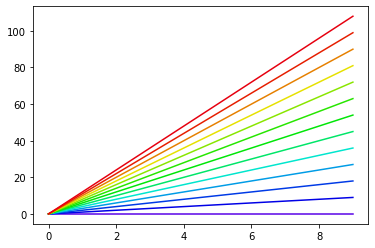

In [11]:
stn_colors = {}
for ss,stn in enumerate(near_shore_stations):
    line_cols = plt.cm.gist_rainbow_r(np.linspace(0.15,1.0,len(near_shore_stations)))[ss]
    darken = 0.1
    #line_cols = plt.cm.Set1_r(np.linspace(0.4,1.0,len(near_shore_stations)))[ss]
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    stn_colors[stn] = line_cols
for ss,stn in enumerate(near_shore_stations):
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[stn])
    


In [12]:
vars_to_compare = {'wspd':'wspd10',
                   'wdir':'wdir10',
                   'temp':'t2'}

# Resample obs and model data:

In [13]:
# Many stations are missing data - these are the good ones:
near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']

In [14]:
for ss,stn in enumerate(near_shore_stations):
    if stn in asos_ds.get_index('station'):
        obs_ds = asos_ds.sel(station=stn)
    elif stn in awos_ds.get_index('station'):
        obs_ds = awos_ds.sel(station=stn)
    #elif stn in apg_ds.get_index('station'):
    #    obs_ds = apg_ds.sel(station=stn)
    else:
        print('no obs for this station: {}'.format(stn))
    if stn == 'APG':
        obs_ds = apg_ds.sel(station='PAA')
        obs_ds.station.data = 'APG'

    obs_res = obs_ds.copy().sel(datetime=slice(t_s,t_e))
    for dd in obs_res.data_vars:
        if dd not in vars_to_compare:
            obs_res = obs_res.drop_vars(dd)
    obs_res = obs_res.resample(datetime='5min').nearest(tolerance='5min')
    if ss == 0:
        obs_res_full = obs_res
    else:
        obs_res_full = xr.concat([obs_res_full,obs_res],dim='station')


In [15]:
def resample_model_output(stn_ds,obs_ds,var_dict,adjustments=None,select_stations=None):
    for vv,var in enumerate(var_dict):
        obs_var = var
        stn_var = var_dict[var]

        temp_ds = stn_ds.copy()
        temp_ds.drop_vars(stn_var)
        temp_var = stn_ds[stn_var].copy()
        if adjustments is not None and len(adjustments) == len(var_dict):
            adjustment = adjustments[vv]
            if adjustment is not None:
                print('Adjusting {} by {}'.format(var,adjustment))
                if adjustment[0] == '+' or adjustment[0] == '-':
                    temp_var += float(adjustment)
                elif adjustment[0] == '*':
                    temp_var = temp_var*float(adjustment[1:])
                elif adjustment[0] == '/':
                    temp_var = temp_var/float(adjustment[1:])
                else:
                    print('adjustment {} not understood. Please use +, -, *, or /'.format(adjustments))
        if select_stations is not None:
            station_list = select_stations
        else:
            station_list = stn_ds.station.data
        for ss,stn in enumerate(station_list):
            if type(obs_ds) == dict:
                obs = obs_ds[stn]
            elif type(obs_ds) == xr.core.dataset.Dataset:
                obs = obs_ds.sel(station=stn)
            else:
                'Need to figure out data type of obs_ds'
            var = temp_var.sel(station=stn)
            
            var[np.where(np.isnan(obs[obs_var].data))] = var[np.where(np.isnan(obs[obs_var].data))]*np.nan

            temp_var.sel(station=stn).data = var.data

        stn_ds[stn_var] = temp_var
    return(stn_ds)

In [16]:
wrf_twrs_res = {}
for cc,case in enumerate(wrf_twrs):        
    wrf_twrs_res[case] = resample_model_output(wrf_twrs[case].copy().sel(datetime=slice(t_s,t_e)).resample(
                                               datetime='5min').nearest(tolerance='5min'),
                                               obs_res_full,var_dict=vars_to_compare,
                                               select_stations=near_shore_stations)

# Taylor Diagrams

In [17]:
remove_mean = False


remove_night = True
night_hour_s = 22
night_hour_e = 12

remove_low_wspds = True
wspd_cutoff = 1.4

only_observed_bb_days = False

save_figs   = False


TD_stns = list(near_shore_stations.copy())
# APG and MTN do not have enough data for the Taylor Diagrams
#TD_stns.remove('APG')
#TD_stns.remove('MTN')

markers = [(i,j,0) for i in np.arange(2,len(cases)*2) for j in range(1, 2)]
markers = ['o','^','P','X','D','p','d','h','v']


'''
#Orig (mar 2020)
bb_observed_dates = {'StaufferThompson2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-09' : ['MTN', 'NAK'],
                                                '2019-07-10' : ['NUI'],
                                                '2019-07-11' : ['NAK'],
                                                '2019-07-15' : ['MTN', 'NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-17' : ['NAK'],
                                                '2019-07-19' : ['MTN'],
                                                '2019-07-20' : ['MTN'],
                                                '2019-07-24' : ['NUI'],
                                                '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                                '2019-07-27' : ['MTN', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                             'Stauffer2015': {  '2019-07-01' : ['NAK'],
                                                '2019-07-07' : ['NHK'],
                                                '2019-07-09' : ['NAK'],
                                                '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NAK', 'NHK'],
                                                '2019-07-28' : ['NAK', 'NHK'],
                                                '2019-07-29' : ['NAK', 'NHK'],
                                                '2019-07-30' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']},
                               'Sikora2010': {  '2019-07-16' : ['NHK'],
                                                '2019-07-27' : ['NHK'],
                                                '2019-07-28' : ['NAK'],
                                                '2019-07-31' : ['NAK', 'NHK']}
                    }

# Old (jul 30, 2020)
bb_observed_dates = {
                    'StaufferThompson2015' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-09' : ['NAK', 'MTN'],
                                              '2019-07-10' : ['NHK', 'NUI'],
                                              '2019-07-15' : ['NAK', 'MTN'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-17' : ['NAK'],
                                              '2019-07-19' : ['NHK', 'MTN', 'NAK'],
                                              '2019-07-20' : ['MTN'],
                                              '2019-07-24' : ['NUI'],
                                              '2019-07-25' : ['NAK', 'NHK'],
                                              '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                              '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-28' : ['NAK', 'NHK'],
                                              '2019-07-29' : ['NAK', 'NHK', 'MTN'],
                                              '2019-07-30' : ['NAK', 'NUI', 'APG', 'NHK'],
                                              '2019-07-31' : ['NAK', 'NHK'],
                                             },
                            'Stauffer2015' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-05' : ['BWI'],
                                              '2019-07-09' : ['NAK', 'MTN'],
                                              '2019-07-10' : ['NHK', 'NUI'],
                                              '2019-07-15' : ['NAK', 'MTN'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-17' : ['NAK'],
                                              '2019-07-19' : ['NHK', 'MTN', 'NAK'],
                                              '2019-07-20' : ['MTN'],
                                              '2019-07-24' : ['NUI'],
                                              '2019-07-25' : ['NAK', 'NHK'],
                                              '2019-07-26' : ['BWI', 'MTN', 'NAK'],
                                              '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-28' : ['NAK', 'MTN', 'NHK'],
                                              '2019-07-29' : ['NAK', 'NHK', 'MTN'],
                                              '2019-07-30' : ['NAK', 'NUI', 'APG', 'NHK'],
                                              '2019-07-31' : ['NHK', 'NAK'],
                                             },
                              'Sikora2010' : {
                                              '2019-07-01' : ['NHK'],
                                              '2019-07-10' : ['NHK'],
                                              '2019-07-15' : ['NAK'],
                                              '2019-07-16' : ['NHK'],
                                              '2019-07-19' : ['NHK'],
                                              '2019-07-25' : ['NAK'],
                                              '2019-07-27' : ['NAK', 'NHK'],
                                              '2019-07-28' : ['NAK'],
                                              '2019-07-29' : ['NAK', 'NHK'],
                                              '2019-07-30' : ['NAK', 'NHK'],
                                              '2019-07-31' : ['NHK'],
                                             },
                    }
'''
bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-24' : ['NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Stauffer2015' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-09' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     'Sikora2010' : {
                                               '2019-07-01' : ['NHK'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['MTN', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NHK'],
                                               '2019-07-27' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-28' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NAK', 'NHK'],
                                              },
                     }


bay_breeze_days_from_obs = []
for meth in bb_observed_dates:
    meth_dates = bb_observed_dates[meth]
    for date in meth_dates:
        bay_breeze_days_from_obs.append(date)
    
bay_breeze_days_from_obs = list(np.unique(bay_breeze_days_from_obs))

#bay_breeze_days_from_obs = ['2019-07-09','2019-07-10','2019-07-11','2019-07-15',
#                            '2019-07-16','2019-07-17','2019-07-19','2019-07-20',
#                            '2019-07-24','2019-07-26','2019-07-27','2019-07-28',
#                            '2019-07-29','2019-07-31']

TD_start = '2019-07-19 00:00:00'
TD_end   = '2019-07-21 00:00:00'

TD_start = t_s
TD_end   = t_e

TD_vars = {'wspd':'wspd10','temp':'t2'}

## Make adjustments to the data as prescribed:

In [18]:
TD_obs_full = {}
plt_start_date = pd.to_datetime(obs_ds.datetime.values[0])
plt_end_date = pd.to_datetime(obs_ds.datetime.values[-1])
for ss,stn in enumerate(TD_stns):
    temp_obs_ds = obs_res_full.sel(station=stn).copy()
    for var in TD_vars:
        obs_var = var
        temp_obs_ds.drop_vars(obs_var)
        obs = obs_res_full.sel(station=stn)[obs_var].copy()

        if obs_var == 'wdir':
            obs = np.cos(np.radians(270. - obs))*np.sin(np.radians(270. - obs))
            obs_var = 'wdir10A'

        if remove_low_wspds and (obs_var == 'wspd' or obs_var == 'wdir'): 
            print(var)
            #obs = obs_ds[['wspd','wdir']].dropna(how='any',dim='datetime')
            obs.data[np.where(obs_res_full.sel(station=stn).wspd.data < wspd_cutoff)] = np.nan
            obs.data[np.where(obs_res_full.sel(station=stn).wspd.data < wspd_cutoff)] = np.nan
            
        if remove_night:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                night_s = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
                night_e = pd.to_datetime('{0}-{1}-{2} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
                obs.sel(datetime=slice(night_s,night_e)).data[:] = obs.sel(datetime=slice(night_s,night_e)).data*np.nan   
                
        if only_observed_bb_days:
            for day in pd.date_range(start=plt_start_date, end=plt_end_date):
                day_str = '{0}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
                if day_str not in bay_breeze_days_from_obs:
                    day_s = pd.to_datetime(day_str)
                    day_e = day_s + pd.Timedelta(1,'d')
                    obs.sel(datetime=slice(day_s,day_e)).data[:] = obs.sel(datetime=slice(day_s,day_e)).data*np.nan
        temp_obs_ds[obs_var] = obs
        
    TD_obs_full[stn] = temp_obs_ds
    

TD_wrf_twrs = {}
for cc,case in enumerate(cases):

    temp_twr_ds = wrf_twrs_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))].copy()

    for vv,var in enumerate(TD_vars):
        obs_var = var
        sim_var = vars_to_compare[var]

        if var != 'wdir':
            temp_twr_ds = temp_twr_ds.drop_vars(sim_var)

        temp_var = wrf_twrs_res['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][sim_var].copy()
        
        for ss,stn in enumerate(TD_stns):
            
            td_var = temp_var.sel(station=stn)

            obs = TD_obs_full[stn][obs_var]
                        
            if var == 'wdir':
                td_var = np.cos(np.radians(270. - td_var))*np.sin(np.radians(270. - td_var))
                sim_var = 'wdir10A'
            td_var[np.where(np.isnan(obs))] = np.nan

            if remove_mean: td_var = td_var - td_var(temp_var,2016/32,0)
                           
            temp_var.sel(station=stn).data[:] = td_var.data[:]

        temp_twr_ds[sim_var] = temp_var
    TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = temp_twr_ds


wspd


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


wspd
wspd
wspd
wspd
wspd


In [19]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

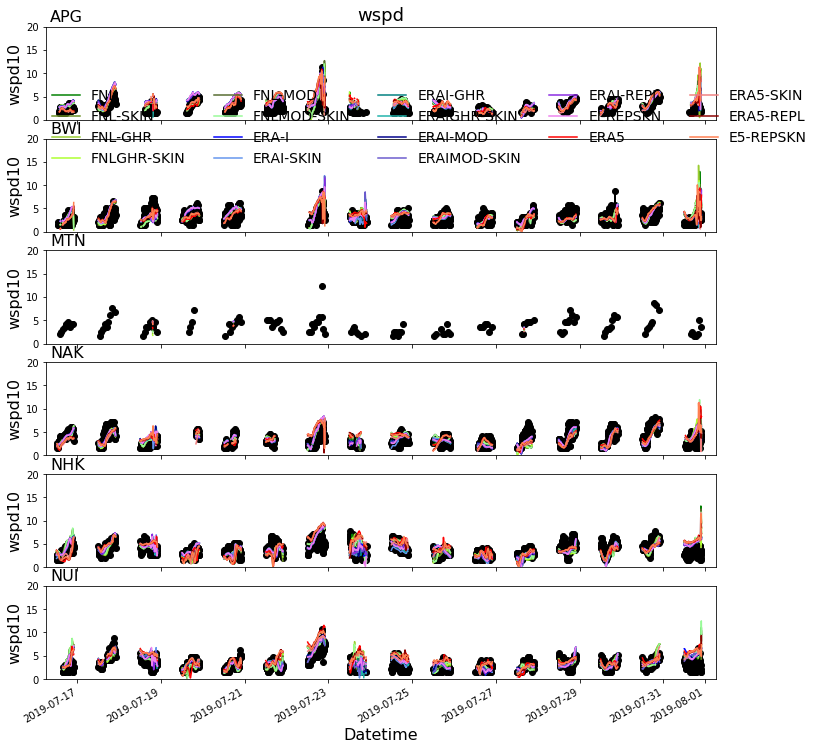

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


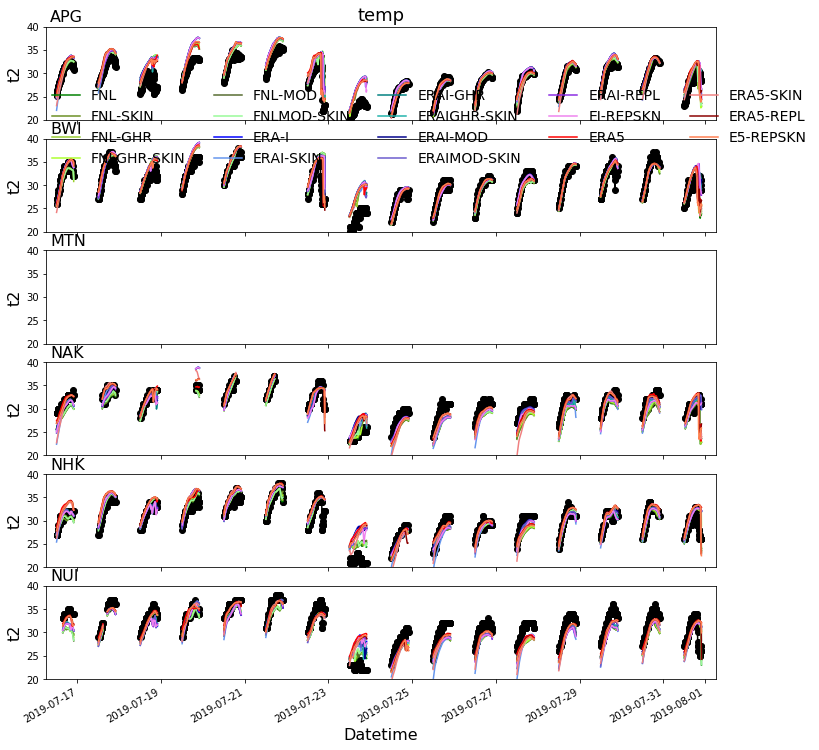

In [20]:
for var in TD_vars:
    obs_var = var
    sim_var = vars_to_compare[var]
    if var == 'wdir': 
        obs_var = 'wdir10A'
        sim_var = 'wdir10A'
        
    fig,ax = plt.subplots(len(TD_stns),sharex=True,figsize=(12,12))
    for ss,stn in enumerate(TD_stns):

        obs = TD_obs_full[stn][obs_var]

        ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

        for cc,case in enumerate(cases_of_interest):
            sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
            case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
            
            if cc == 0:
                obs_plt = obs#.dropna(how='any',dim='datetime')
                obs_plt.plot(ax=ax[ss],c='k',marker='o')

            sim_plt = sim#.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax[ss],label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])

        ax[ss].set_ylabel(sim_var,size=16)
        if ss == len(TD_stns) - 1:
            ax[ss].set_xlabel('Datetime',size=16)
        else:
            ax[ss].set_xlabel('')
        if ss == 0:
            ax[ss].set_title(var,size=18)
        else:
            ax[ss].set_title('')
        
        if var == 'wspd':
            ymin,ymax = 0,20
        if var == 'wdir':
            ymin,ymax = 0,360
        if var == 'temp':
            ymin,ymax = 20,40
            
        ax[ss].set_ylim(ymin,ymax)

        ax[ss].set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
        ax[ss].text(sim.datetime.data[30],ymax + 0.02*(ymax-ymin),stn,va='bottom',ha='left',size=16)
    ax[1].legend(frameon=False,ncol=5,loc=(0.,0.65),fontsize=14)
    plt.show()

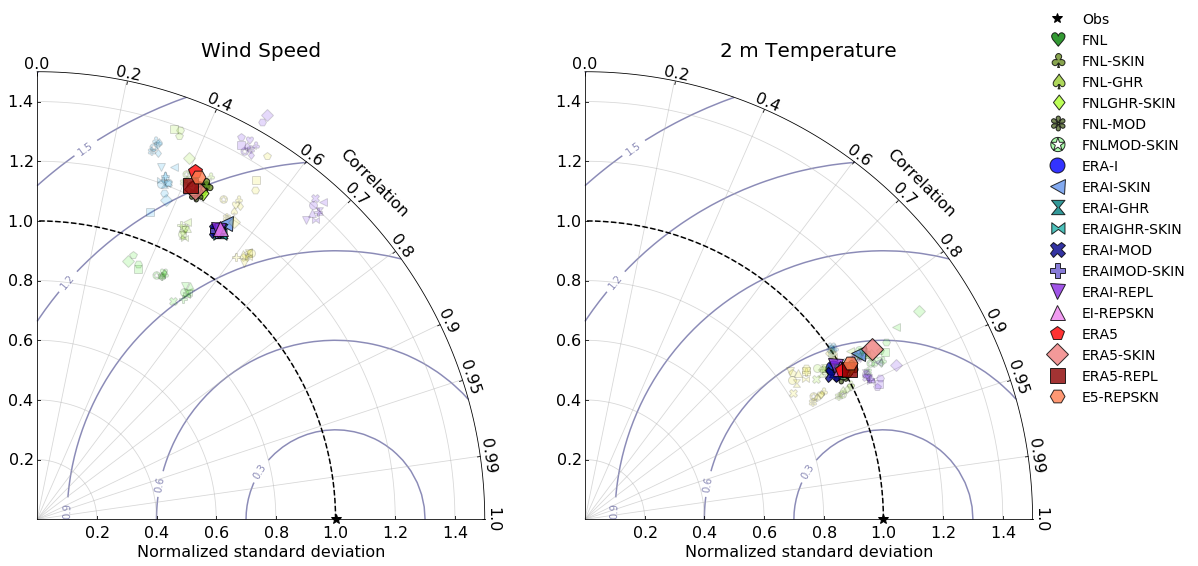

In [21]:
fig_tay = plt.figure(figsize=(18,9))
for vv,var in enumerate(['wspd','temp']):
    if var != 'wdir':
        obs_var = var
        sim_var = vars_to_compare[var]
    else:
        obs_var = '{}A'.format(var)
        sim_var = '{}A'.format(vars_to_compare[var])
    if var == 'wspd':
        var_str = 'Wind Speed'
    elif var == 'temp':
        var_str = '2 m Temperature'
    
    dia = TaylorDiagram(1.0, fig=fig_tay, 
                        extend=False,
                        label='Obs',
                        rect=121+vv,
                        normalize=True,
                        srange=[0.0,1.50],
                        stdevticks=np.arange(0.2,5.6,0.2),
                        labelsize=16)
    
    td_stats = {}
    for cc,case in enumerate(cases_of_interest):
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
        td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

        for ss,stn in enumerate(TD_stns):
            if stn != 'MTN':

                obs = TD_obs_full[stn][obs_var]
                obs = obs.dropna(how='any',dim='datetime')
                sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
                sim = sim.dropna(how='any',dim='datetime')
                
                ref_std = np.std(obs.data)
                sim_std = np.std(sim.data)

                r2,_ = pearsonr(sim, obs)

                if ss == 0: 
                    obs_full = obs - np.nanmean(obs)
                    sim_full = sim - np.nanmean(sim)
                    #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
                    label_str = None
                else:
                    obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
                    sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
                    label_str = None
                #print(case,stn,np.std(sim.data)/ref_std)
                if case_plt_dict['fill']:
                    marker_c = stn_colors[stn]
                    marker_e = 'k'
                else:
                    marker_c = stn_colors[stn]
                    marker_e = stn_colors[stn]
                td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
                td_stats[case].loc[stn,'R2'] = r2
                
                dia.set_ref(ref_std)

                dia.add_sample(np.std(sim.data), r2,
                               marker=case_plt_dict['marker'], ms=8, ls='',
                               mfc=marker_c, mec=marker_e, # Colors
                               label=label_str,
                               zorder=cc,alpha=0.15)

                #if cc == 0:
                    #txt_x = 0.38 + 0.17*stn_count
                    #txt_y = 0.12
                    #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                    #plt.text(txt_x,txt_y-0.08,'{0:2.2f}'.format(ref_std),size=18,ha='center')
                    #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

            multimodal_mean = False
        
        if multimodal_mean:
            ref_std_full = np.std(obs_full)

            dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.7)
        else:        
            td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
            td_mean = td_stats[case].mean(axis=0)
            dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                   norm=False, # don't normalize this point
                   marker=case_plt_dict['marker'], ms=15, ls='',
                   mfc=case_plt_dict['color'], mec='k', # Colors
                   label=case_plt_dict['name'],
                   zorder=cc+3,alpha=0.8)
    contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
    dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    dia.add_grid(alpha=0.5)
    if vv == 1: 
        plt.legend(frameon=False,fontsize=14,loc=(1.0,0.25),ncol=1)
    plt.title('{}'.format(var_str),size=20,y=1.01)
plt.show()
    
    
        

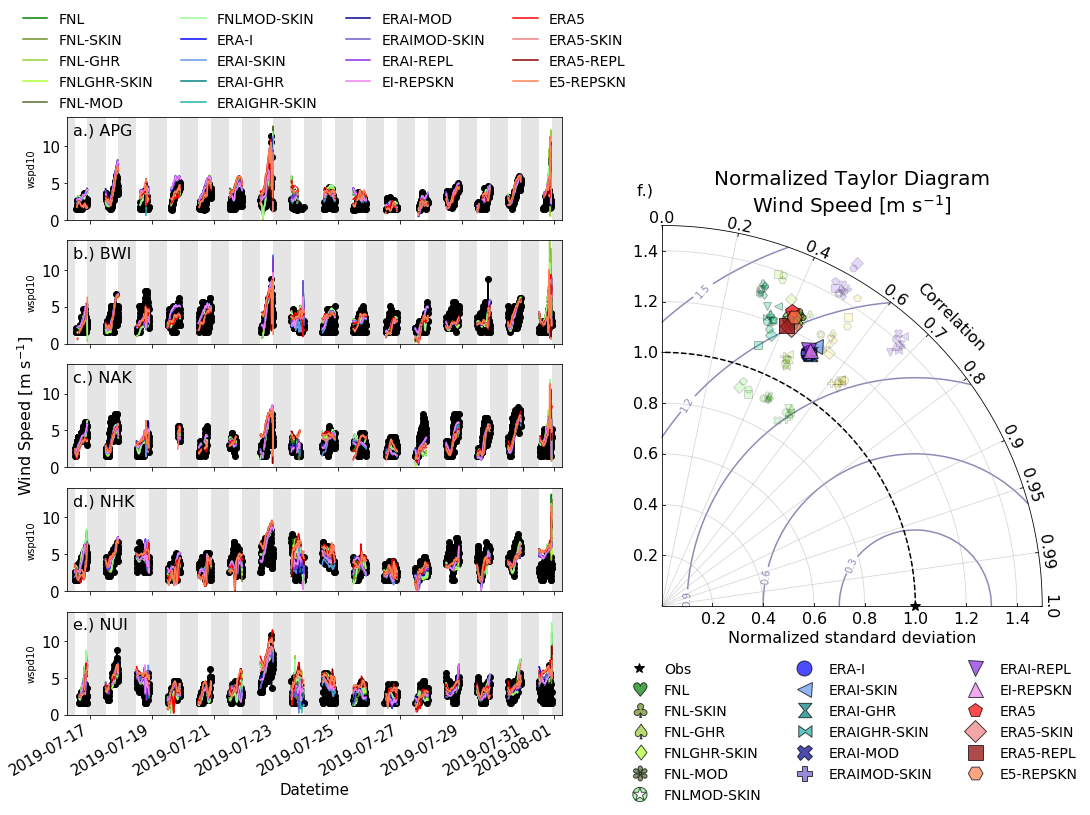

In [22]:
ymin,ymax = 0,14
ylabel = 'Wind Speed [m s$^{-1}$]'
sim_var = 'wspd10'
obs_var = 'wspd'
var_str = 'Wind Speed [m s$^{-1}$]'

fig = plt.figure(figsize=(16,11.0))
plt.subplots_adjust(wspace=0.3)

TD_stns_plt = TD_stns.copy()
TD_stns_plt.remove('MTN')
gs1 = gridspec.GridSpec(len(TD_stns_plt), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(TD_stns_plt):
    ax1 = plt.subplot(gs1[ss])

    obs = TD_obs_full[stn][obs_var] 

    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]


        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim #.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    if ss == 2: ax1.set_ylabel(ylabel,size=16)
    if ss == 4:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date - pd.to_timedelta(1,'d'), end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    txt_y = txt_y = ymin + 0.8*(ymax-ymin)
    #if (stn == 'APG') or (stn == 'BWI'): txt_y = ymin + 0.80*(ymax-ymin)
    ax1.text(obs.datetime.data[60],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(-0.1,1.01),fontsize=14,handlelength=1.75)


        
extend = False
TD_max_r = 1.5

dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}

for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):
        if stn != 'MTN':

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.51),ncol=3)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.03,1.62,'f.)',size=16,ha='right')
plt.show()

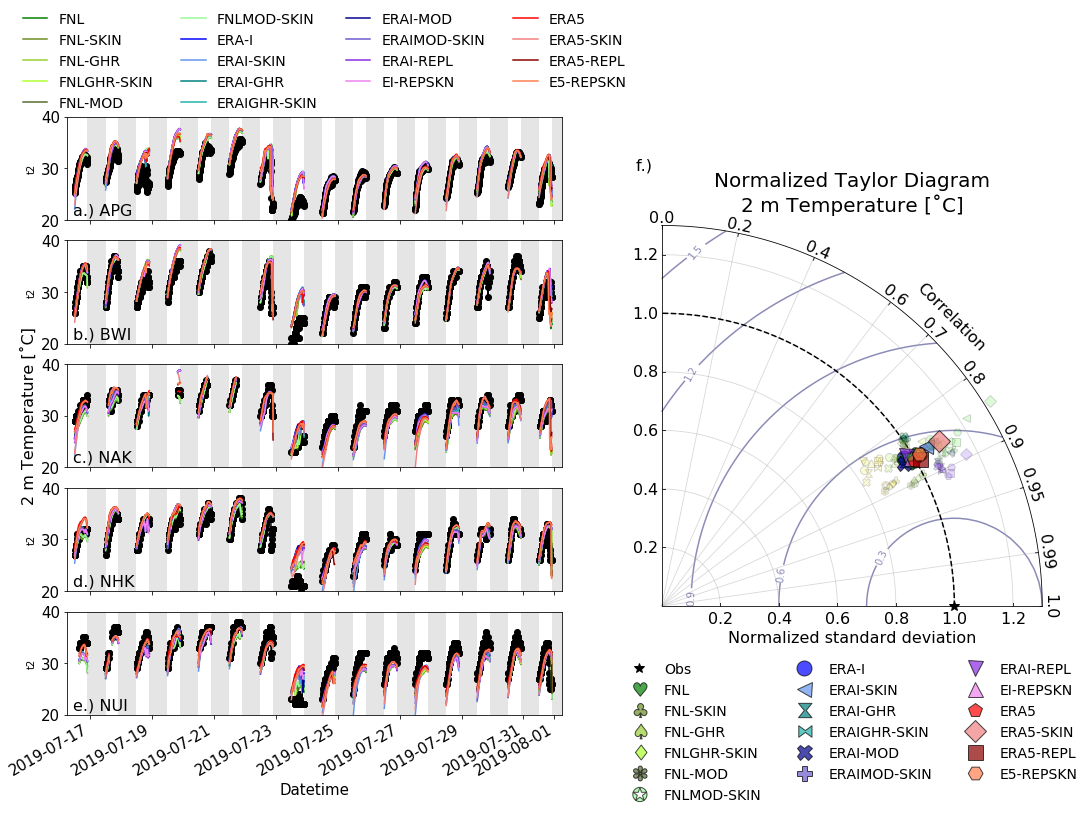

In [23]:
ymin,ymax = 20,40
ylabel = '2 m Temperature [˚C]'
sim_var = 't2'
obs_var = 'temp'
var_str = '2 m Temperature'

fig = plt.figure(figsize=(16,11.0))
plt.subplots_adjust(wspace=0.3)

TD_stns_plt = TD_stns.copy()
TD_stns_plt.remove('MTN')
gs1 = gridspec.GridSpec(len(TD_stns_plt), 1)
gs1.update(left=0.05, right=0.48, wspace=0.05)
#ax1 = plt.subplot(gs1[0])
#ax2 = plt.subplot(gs1[1])
#ax3 = plt.subplot(gs1[2])
#ax4 = plt.subplot(gs1[3])

for ss,stn in enumerate(TD_stns_plt):
    ax1 = plt.subplot(gs1[ss])

    obs = TD_obs_full[stn][obs_var] 

    ref_std = np.std(obs.dropna(how='any',dim='datetime').data)

    for cc,case in enumerate(cases_of_interest):
        sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]


        if cc == 0:
            obs_plt = obs#.dropna(how='any',dim='datetime')
            if len(obs.dropna(how='any',dim='datetime')) > 2:
                obs_plt.plot(ax=ax1,c='k',marker='o')
        if len(sim.dropna(how='any',dim='datetime')) > 2:
            sim_plt = sim #.dropna(how='any',dim='datetime')
            sim_plt.plot(ax=ax1,label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])
    ax1.set_title('')
    if ss == 2: ax1.set_ylabel(ylabel,size=16)
    if ss == 4:
        ax1.set_xlabel('Datetime',size=15)
        ax1.tick_params(labelsize=15)
    else:
        ax1.set_xlabel('')
        ax1.tick_params(labelbottom=False,labelsize=15)
    plt_start_date = pd.to_datetime(obs.datetime.values[0])
    plt_end_date = pd.to_datetime(obs.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date, end=plt_end_date):
        night_s = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_s))
        night_e = pd.to_datetime('{0:04d}-{1:02d}-{2:02d} {3:02d}:00'.format(day.year,day.month,day.day,night_hour_e)) + pd.Timedelta(1,'d')
        ax1.fill_betweenx([-100,400],night_s,night_e,facecolor='k',alpha=0.1)   
    txt_y = txt_y = ymin + 0.02*(ymax-ymin)
    #if (stn == 'APG') or (stn == 'BWI'): txt_y = ymin + 0.80*(ymax-ymin)
    ax1.text(obs.datetime.data[60],txt_y,'{}.) {}'.format(ascii_lowercase[ss],stn),va='bottom',ha='left',size=16)
    ax1.set_ylim(ymin,ymax)
    ax1.set_xlim(sim.datetime.data[0],sim.datetime.data[-1])
    if ss == 0: ax1.legend(frameon=False,ncol=4,loc=(-0.1,1.01),fontsize=14,handlelength=1.75)


        
extend = False
TD_max_r = 1.3

dia = TaylorDiagram(1.0, fig=fig, 
                    extend=extend,
                    rect=122,
                    label='Obs',
                    normalize=True,
                    srange=[0.0,TD_max_r],
                    stdevticks=np.arange(0.2,5.6,0.2),
                    labelsize=16)
td_stats = {}

for cc,case in enumerate(cases_of_interest):
    case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
    td_stats[case] = pd.DataFrame(index=TD_stns, columns=['std_norm','R2'], dtype=float) 

    for ss,stn in enumerate(TD_stns):
        if stn != 'MTN':

            obs = TD_obs_full[stn][obs_var]
            obs = obs.dropna(how='any',dim='datetime')
            sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
            sim = sim.dropna(how='any',dim='datetime')

        ref_std = np.std(obs.data)
        sim_std = np.std(sim.data)

        r2,_ = pearsonr(sim, obs)

        if ss == 0: 
            obs_full = obs - np.nanmean(obs)
            sim_full = sim - np.nanmean(sim)
            #label_str = '_'.join(case.replace('_KF','').split('_')[1:])
            label_str = None
        else:
            obs_full = np.concatenate([obs_full,obs - np.nanmean(obs)])
            sim_full = np.concatenate([sim_full,sim - np.nanmean(sim)])
            label_str = None
        #print(case,stn,np.std(sim.data)/ref_std)
        if case_plt_dict['fill']:
            marker_c = stn_colors[stn]
            marker_e = 'k'
        else:
            marker_c = stn_colors[stn]
            marker_e = stn_colors[stn]

        td_stats[case].loc[stn,'std_norm'] = sim_std/ref_std
        td_stats[case].loc[stn,'R2'] = r2

        dia.set_ref(ref_std)

        dia.add_sample(np.std(sim.data), r2,
                       marker=case_plt_dict['marker'], ms=8, ls='',
                       mfc=marker_c, mec=marker_e, # Colors
                       label=label_str,
                       zorder=cc,alpha=0.15)

            #if cc == 0:
            #    txt_x = 0.38 + 0.17*stn_count
            #    txt_y = 0.12
                #plt.text(txt_x,txt_y,'{0}'.format(stn),c=stn_colors[stn],size=22,ha='center')
                #plt.text(txt_x,txt_y-0.08,'{0:2.1f}'.format(ref_std),size=18,ha='center')
                #if ss == 0: plt.text(txt_x-0.1,txt_y-0.08,'ref. STD: ',size=18,ha='right')

    multimodal_mean = False

    if multimodal_mean:
        ref_std_full = np.std(obs_full)

        #dia.add_sample(np.std(sim_full)/ref_std_full, np.corrcoef(sim_full,obs_full)[0,1],
        #       marker=case_plt_dict['marker'], ms=15, ls='',
        #       mfc=case_plt_dict['color'], mec='k', # Colors
        #       label=case_plt_dict['name'],
        #       zorder=cc+3,alpha=0.7)
    else:        
        td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
        td_mean = td_stats[case].mean(axis=0)
        dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
               norm=False, # don't normalize this point
               marker=case_plt_dict['marker'], ms=15, ls='',
               mfc=case_plt_dict['color'], mec='k', # Colors
               label=case_plt_dict['name'],
               zorder=cc+3,alpha=0.7)
contours = dia.add_contours(levels=5, colors='midnightblue',alpha=0.50,zorder=1)
dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
dia.add_grid(alpha=0.5)
plt.legend(frameon=False,fontsize=14,loc=(-0.1,-0.51),ncol=3)
plt.title('Normalized Taylor Diagram\n{}'.format(''.join(ylabel.split('\n')[0])),size=20,y=1.01)
plt.text(-0.03,1.49,'f.)',size=16,ha='right')
plt.show()

# Detect Bay Breeze

In [24]:
# Start time:     0900 Local (1300 UTC) 
start_time = pd.to_timedelta(13,unit='h')
# End time:       1600 Local (2000 UTC)
end_time   = pd.to_timedelta(20,unit='h')

detection_methods = ['StaufferThompson2015','Stauffer2015','Sikora2010']

In [25]:
cases_of_interest

['GFSR_YSU_CHRN_GFS_NOSK_3DOM',
 'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
 'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
 'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
 'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
 'GFSR_YSU_CHRN_MOD_SKNT_3DOM',
 'ERAI_YSU_CHRN_OST_NOSK_4DOM',
 'ERAI_YSU_CHRN_OST_SKNT_3DOM',
 'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
 'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
 'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
 'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
 'ERAI_YSU_CHRN_OST_OVER_3DOM',
 'ERAI_YSU_CHRN_OST_OVSK_3DOM',
 'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
 'ERA5_YSU_CHRN_ER5_SKNT_3DOM',
 'ERA5_YSU_CHRN_ER5_OVER_3DOM',
 'ERA5_YSU_CHRN_ER5_OVSK_3DOM']

In [26]:
bb_detection_dict_fname = '{}wrf_bay_breeze_detections_final_new.txt'.format(wrf_dir)
if path.exists(bb_detection_dict_fname):
    print('loading in full dataframe!')
    bb_case_df = pd.read_csv(bb_detection_dict_fname,delimiter='\t',names=['case','method','station','detection_dates'])
else:
    bb_case_dict = {}
    for cc,case in enumerate(cases_of_interest):
        bb_case_dict['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))] = {}
        for dm,detection_method in enumerate(detection_methods):
            print(detection_method)
            bb_case_dict['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][detection_method] = {}
            for dd,day in enumerate(pd.date_range(start=t_s - pd.to_timedelta(t_s.hour,'h') - pd.to_timedelta(t_s.second,'s'), end=t_e)):
                twr_dat_f = wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))]
                if dd == 0:
                    bb_stn_dict = {}
                for stn in near_shore_stations:
                    if dd == 0: 
                        bb_stn_dict[stn] = []
                    #fig,ax = plt.subplots(nrows=2,figsize=(10,7),sharex=True)

                    if stn in asos_ds.get_index('station'):
                        obs_ds = asos_ds.sel(station=stn).sel(datetime=slice(t_s,t_e))
                    elif stn in awos_ds.get_index('station'):
                        obs_ds = awos_ds.sel(station=stn).sel(datetime=slice(t_s,t_e))
                    else:
                        print('no obs for this station')
                    #obs_ds = obs_res_full.sel(station=stn)
                    twr_dat = twr_dat_f.sel(station=stn)
                    twr_dat['onshore_max'] = obs_ds.onshore_max
                    twr_dat['onshore_min'] = obs_ds.onshore_min
                    if stn == 'APG':
                        obs_ds = apg_ds.sel(station='PAA')
                        obs_ds.station.data = 'APG'
                        
                    if detection_method == 'Stauffer2015':
                        twr_dat['dwpt'] = T_d(twr_dat.t2,100.0*(twr_dat.q2/w_s(twr_dat.t2, twr_dat.psfc/100.0)))



                    station         = twr_dat.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                 str(pd.to_datetime(day)+end_time))).isel(nz=0)
                    inland_stations = wrf_twrs['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))].sel(station=ref_stn).sel(
                                                 datetime=slice(str(pd.to_datetime(day)+start_time),
                                                 str(pd.to_datetime(day)+end_time))).isel(nz=0)


                    bay_breeze      = DetectBayBreeze(station,inland=inland_stations,verbose=False,resample=True,
                                                      sample_rate='30min',show_plot=False,method=detection_method) 
                    if bay_breeze.detected:
                        bb_stn_dict[stn] = np.concatenate([bb_stn_dict[stn],[str(day)]])
            for stn in near_shore_stations[0:]:
                bb_case_dict['{}_{}'.format(case,'d0{}'.format(case_dom[cc]))][detection_method][stn] = bb_stn_dict[stn]


    new_f = open(bb_detection_dict_fname,'w')
    for case in bb_case_dict:
        for det_meth in bb_case_dict[case]:
            for stn in bb_case_dict[case][det_meth]:
                detections = bb_case_dict[case][det_meth][stn]
                detections = ','.join(detections)
                if detections == '':
                    detections = 'None'
                else:
                    detections = detections.replace(' ','_')
                new_f.write('{}\t{}\t{}\t{}\n'.format(case, det_meth,stn,detections))
    new_f.close()
    bb_case_df = pd.read_csv(bb_detection_dict_fname,delimiter='\t',names=['case','method','station','detection_dates'])


loading in full dataframe!


# Make LaTeX Table for the cases:

### Need to split the table into 2 or more pieces...

In [27]:
stn_str_dict = {'APG':'A',
                'BWI':'B',
                'NAK':'K',
                'NHK':'H',
                'NUI':'N',
                'MTN':'M'}

mth_str_dict = {'StaufferThompson2015' : 'ST',
                        'Stauffer2015' : 'S',
                          'Sikora2010' : 'K'}

cases_table_full = [
                     ['GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                      'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
                      'GFSR_YSU_CHRN_GHR_NOSK_3DOM'],
    
                     ['GFSR_YSU_CHRN_GHR_SKNT_3DOM',
                      'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                      'GFSR_YSU_CHRN_MOD_SKNT_3DOM',],

                     ['ERAI_YSU_CHRN_OST_NOSK_4DOM',
                      'ERAI_YSU_CHRN_OST_SKNT_3DOM',
                      'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                      'ERAI_YSU_CHRN_GHR_SKNT_3DOM'],
    
                     ['ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                      'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
                      'ERAI_YSU_CHRN_OST_OVER_3DOM',
                      'ERAI_YSU_CHRN_OST_OVSK_3DOM'],

                     ['ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                      'ERA5_YSU_CHRN_ER5_SKNT_3DOM'],
                     ['ERA5_YSU_CHRN_ER5_OVER_3DOM',
                      'ERA5_YSU_CHRN_ER5_OVSK_3DOM']
                    ]


# LaTeX color definitions

In [28]:
for stn_c in stn_colors:
    print(r'\definecolor{'+stn_c+'}{rgb}{' + '{},{},{}'.format(stn_colors[stn_c][0],stn_colors[stn_c][1],stn_colors[stn_c][2]) + '}')

\definecolor{APG}{rgb}{0.3401108269394716,0.0,0.9}
\definecolor{BAR}{rgb}{0.0,0.0,0.9}
\definecolor{BBB}{rgb}{0.0,0.22715260017050262,0.9}
\definecolor{BWI}{rgb}{0.0,0.6107843137254901,0.9}
\definecolor{MFD}{rgb}{0.0,0.9,0.8065991988193129}
\definecolor{MIR}{rgb}{0.0,0.9,0.4060088551549653}
\definecolor{MTN}{rgb}{0.0,0.9,0.026502213788741263}
\definecolor{NAK}{rgb}{0.15437201907790135,0.9,0.0}
\definecolor{NHK}{rgb}{0.5359300476947535,0.9,0.0}
\definecolor{NUI}{rgb}{0.9,0.8825119236883945,0.0}
\definecolor{OBO}{rgb}{0.9,0.5009538950715423,0.0}
\definecolor{PAA}{rgb}{0.9,0.11939586645468989,0.0}
\definecolor{SPI}{rgb}{0.9,0.0,0.06}


# Confusion matrix dictionary:

In [29]:
confusion_matrix_dict = {}
for case in np.unique([item for sublist in cases_table_full for item in sublist]):
    confusion_matrix_dict['{}_d03'.format(case)] = {}
    for meth in detection_methods:
        confusion_matrix_dict['{}_d03'.format(case)][meth] = {}

n_bb_stn = 6 # 6 if you do APG

# BIG TABLE!

In [30]:
confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
stn_cnt = 0
for tt,cases_table in enumerate(cases_table_full):
    for dd,day in enumerate(pd.date_range(start=t_s, end=t_e)):
#    for dd,day in enumerate(pd.date_range(start=t_s, end=pd.to_datetime('2019-07-18'))):
        count = 0
        date_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
        if date_str in bay_breeze_days_from_obs:
            day_str = r'\textbf{' + date_str + r'}'
        else:
            day_str = date_str
        day_line = '{} & '.format(day_str)
        init_line = True
        for row in bb_case_df.T.iteritems(): 

            case   = row[1][0]
            method = row[1][1]
            stn    = row[1][2]
            dates  = row[1][3].replace('_',' ')
            stn_str_f = stn_str_dict[stn]
            bb_obs = False
            bb_sim = False
            if '_'.join(case.split('_')[:-1]) in cases_table and case.split('_')[-1] == 'd03':
                stn_cnt += 1
                if init_line:
                    prev_method = method
                    prev_case   = case

                    header_1    = ' & \multicolumn{3}{c||}{' + case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                    header_2    = ' Date & {}'.format(mth_str_dict[method])
                    hd2_fmt     = '|r|c|'
                    init_line = False
                    #print(date_str,bb_observed_dates[method][date_str])

                if method != prev_method:
                    day_line = day_line[:-1] + ' & '
                    if dd == 0:
                        if case != prev_case:
                            header_1 = header_1 + '\multicolumn{3}{c||}{' + \
                                       case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                            header_2 = header_2 + ' & {}'.format(mth_str_dict[method])
                            hd2_fmt = hd2_fmt + '|c|'
                        else:
                            header_2 = header_2 + ' & {}'.format(mth_str_dict[method])
                            hd2_fmt = hd2_fmt + 'c|'

                if case != prev_case:
                    day_line = day_line[:-1] + ' '
                    
                if date_str in dates:
                    #print('{} simulated a bb on this date'.format(stn))
                    bb_sim = True
                    stn_str_f = r'\textcolor{' + stn + '}{'+ stn_str_f + r'}'
                else:
                    #print('{} did not simulate a bb on this date'.format(stn))
                    stn_str_f = stn_str_f                    
                if date_str in bb_observed_dates[method]:

                    bay_breeze_stations_for_this_date = bb_observed_dates[method][date_str]

                    if stn in bay_breeze_stations_for_this_date:
                        #print('{} observed a bb on this date'.format(stn))
                        bb_obs = True
                        stn_str_f = r'\textbf{' + stn_str_f + r'}'
                    else:
                        stn_str_f = stn_str_f                    
                    #    print('{} did not observe a bb on this date'.format(stn))
                else:
                    stn_str_f = stn_str_f

                
                day_line = day_line + '{} '.format(stn_str_f)
                
                
                if bb_sim and bb_obs:
                    #print('True Positive')
                    confusion_matrix['TP'] += 1
                if bb_sim and not bb_obs:
                    #print('False Positive')
                    confusion_matrix['FP'] += 1
                if not bb_sim and not bb_obs:
                    #print('True Negative')
                    confusion_matrix['TN'] += 1
                if not bb_sim and bb_obs:
                    #print('False Negative')
                    confusion_matrix['FN'] += 1
                    
                if stn_cnt == n_bb_stn:
                    if dd == 0:
                        confusion_matrix_dict[case][method] = confusion_matrix
                    else:
                        for val in confusion_matrix_dict[case][method]:
                            #print(val)
                            confusion_matrix_dict[case][method][val] += confusion_matrix[val]
                    confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
                    stn_cnt = 0
                

                prev_method = method
                prev_case   = case        
                #print()
                count+=1
                #if count > 9:
                #    print(day_line)
                #    wefwef

        
        if dd == 0:
            header_1 = header_1[:-1] + ' \\\ \n'
            header_2 = header_2 + ' \\\ \n'


            if tt == 0:
                print(r'\begin{landscape}')
                print(r'\thispagestyle{empty}')
                print(r'    \noindent')
                print(r'\renewcommand{\arraystretch}{0.65}')
                print(r'\footnotesize')
            print(r'\begin{tabular}{ '+hd2_fmt+' }')
            print(r'\hline')
            print(header_1)
            print(r'\hline')
            print(header_2)
            print(r'\hline')
            print(r'\hline')
        day_line = day_line[:-1] + ' \\\ \n'

        print(day_line)
        print(r'\hline')
    print(r'\end{tabular}')

    
    print()
    print()
    print()
    
print(r'\renewcommand{\arraystretch}{1.0}')
print(r'\end{landscape}')    
   
    
    
    

\begin{landscape}
\thispagestyle{empty}
    \noindent
\renewcommand{\arraystretch}{0.65}
\footnotesize
\begin{tabular}{ |r|c|c|c||c|c|c||c|c|c| }
\hline
 & \multicolumn{3}{c||}{FNL} &\multicolumn{3}{c||}{FNL-SKIN} &\multicolumn{3}{c||}{FNL-GHR}  \\ 

\hline
 Date & ST & S & K & ST & S & K & ST & S & K \\ 

\hline
\hline
\textbf{2019-07-16} & A B M \textcolor{NAK}{K} \textbf{H} N & A B M \textcolor{NAK}{K} H N & A B M K \textbf{H} N & A B M \textcolor{NAK}{K} \textbf{H} N & A B M \textcolor{NAK}{K} H N & A B M K \textbf{H} N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} \textbf{H} N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B M K \textbf{H} N \\ 

\hline
2019-07-17 & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B M K H N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B M K H N & \textcolor{APG}{A} B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & \textcolor{APG}{A} B \textcolor{

In [31]:
from IPython.core.display import HTML,display

color="255,127,80"  # coral

def print_color(text,c):
    source = "<h1 style='color: rgb({1})'> {0} </h1>".format(text,c)
    return HTML(source)

for ss,stn in enumerate(['APG','BWI','MTN','NAK','NHK','NUI']):
    color_str = '{},{},{}'.format(stn_colors[stn][0]*256,stn_colors[stn][1]*256,stn_colors[stn][2]*256)
    display(print_color('{} = {}'.format(stn_str_dict[stn],stn),color_str))


In [32]:
for case in confusion_matrix_dict:
    for meth in confusion_matrix_dict[case]:
        print(case,meth,sum(confusion_matrix_dict[case][meth].values()))

ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 Stauffer2015 96
ERA5_YSU_CHRN_ER5_NOSK_3DOM_d03 Sikora2010 96
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 Stauffer2015 96
ERA5_YSU_CHRN_ER5_OVER_3DOM_d03 Sikora2010 96
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 Stauffer2015 96
ERA5_YSU_CHRN_ER5_OVSK_3DOM_d03 Sikora2010 96
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 StaufferThompson2015 96
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 Stauffer2015 96
ERA5_YSU_CHRN_ER5_SKNT_3DOM_d03 Sikora2010 96
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 Stauffer2015 96
ERAI_YSU_CHRN_GHR_NOSK_3DOM_d03 Sikora2010 96
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 Stauffer2015 96
ERAI_YSU_CHRN_GHR_SKNT_3DOM_d03 Sikora2010 96
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 StaufferThompson2015 96
ERAI_YSU_CHRN_MOD_NOSK_3DOM_d03 Stauffer2015

# Big table summary:

In [33]:
n_methods = len(mth_str_dict)
#print(r'\thispagestyle{empty}')
#print(r'    \noindent')
print(r'\renewcommand{\arraystretch}{0.65}')
print(r'\small')
print(r'\begin{tabular}{ |c|c|c|c|c|c|}')
print(r'\hline')
print(r'Case & Method & TP & TN & FP & FN \\ ')
print(r'\hline')
for cc,case in enumerate(cases_of_interest):
    case_n = case_dict[case]['d03']['name']
    case_str = r'\multirow{' + str(n_methods) + r'}{*}{' + case_n + r'} &'
    print(case_str)
    for mm,method in enumerate(confusion_matrix_dict['{}_d03'.format(case)]):
        c_matrix = confusion_matrix_dict['{}_d03'.format(case)][method]
        if mm == 0:
            c_matrix_str = ' {0} & {1} & {3} & {2} & {4} \\\ '.format(method,c_matrix['TP'],c_matrix['FP'],c_matrix['TN'],c_matrix['FN'])
        else:
            c_matrix_str = '&  {0} & {1} & {3} & {2} & {4} \\\ '.format(method,c_matrix['TP'],c_matrix['FP'],c_matrix['TN'],c_matrix['FN'])
        print(c_matrix_str)
    print(r'\hline')
print(r'\end{tabular}')

print(r'\renewcommand{\arraystretch}{1.0}')


\renewcommand{\arraystretch}{0.65}
\small
\begin{tabular}{ |c|c|c|c|c|c|}
\hline
Case & Method & TP & TN & FP & FN \\ 
\hline
\multirow{3}{*}{FNL} &
 StaufferThompson2015 & 1 & 77 & 6 & 12 \\ 
&  Stauffer2015 & 1 & 78 & 7 & 10 \\ 
&  Sikora2010 & 0 & 88 & 0 & 8 \\ 
\hline
\multirow{3}{*}{FNL-SKIN} &
 StaufferThompson2015 & 2 & 76 & 7 & 11 \\ 
&  Stauffer2015 & 2 & 78 & 7 & 9 \\ 
&  Sikora2010 & 0 & 87 & 1 & 8 \\ 
\hline
\multirow{3}{*}{FNL-GHR} &
 StaufferThompson2015 & 2 & 73 & 10 & 11 \\ 
&  Stauffer2015 & 2 & 75 & 10 & 9 \\ 
&  Sikora2010 & 0 & 86 & 2 & 8 \\ 
\hline
\multirow{3}{*}{FNLGHR-SKIN} &
 StaufferThompson2015 & 2 & 76 & 7 & 11 \\ 
&  Stauffer2015 & 2 & 77 & 8 & 9 \\ 
&  Sikora2010 & 0 & 86 & 2 & 8 \\ 
\hline
\multirow{3}{*}{FNL-MOD} &
 StaufferThompson2015 & 2 & 79 & 4 & 11 \\ 
&  Stauffer2015 & 2 & 81 & 4 & 9 \\ 
&  Sikora2010 & 0 & 87 & 1 & 8 \\ 
\hline
\multirow{3}{*}{FNLMOD-SKIN} &
 StaufferThompson2015 & 1 & 78 & 5 & 12 \\ 
&  Stauffer2015 & 1 & 80 & 5 & 10 \\ 
&  Siko

# Summary table summary...

In [34]:

print(r'\renewcommand{\arraystretch}{0.65}')
print(r'\begin{tabular}{ |c|c|c|c|c|}')
print(r'\hline')
print(r'Case & TP & TN & FP & FN \\ ')
print(r'\hline')
for cc,case in enumerate(cases_of_interest):
    case_n = case_dict[case]['d03']['name']
    case_str = case_n + r' &'
    print(case_str)
    for mm,method in enumerate(confusion_matrix_dict['{}_d03'.format(case)]):
        c_matrix = confusion_matrix_dict['{}_d03'.format(case)][method]
        if mm == 0:
            TP_count = c_matrix['TP']
            FP_count = c_matrix['FP']
            TN_count = c_matrix['TN']
            FN_count = c_matrix['FN']
        else:
            TP_count += c_matrix['TP']
            FP_count += c_matrix['FP']
            TN_count += c_matrix['TN']
            FN_count += c_matrix['FN']
    c_matrix_str = ' {0} & {1} & {2} & {3} \\\ '.format(TP_count,TN_count,FP_count,FN_count)
    print(c_matrix_str)
    print(r'\hline')
print(r'\end{tabular}')

print(r'\renewcommand{\arraystretch}{1.0}')


\renewcommand{\arraystretch}{0.65}
\begin{tabular}{ |c|c|c|c|c|}
\hline
Case & TP & TN & FP & FN \\ 
\hline
FNL &
 2 & 243 & 13 & 30 \\ 
\hline
FNL-SKIN &
 4 & 241 & 15 & 28 \\ 
\hline
FNL-GHR &
 4 & 234 & 22 & 28 \\ 
\hline
FNLGHR-SKIN &
 4 & 239 & 17 & 28 \\ 
\hline
FNL-MOD &
 4 & 247 & 9 & 28 \\ 
\hline
FNLMOD-SKIN &
 2 & 245 & 11 & 30 \\ 
\hline
ERA-I &
 6 & 235 & 21 & 26 \\ 
\hline
ERAI-SKIN &
 2 & 244 & 12 & 30 \\ 
\hline
ERAI-GHR &
 7 & 235 & 21 & 25 \\ 
\hline
ERAIGHR-SKIN &
 5 & 233 & 23 & 27 \\ 
\hline
ERAI-MOD &
 2 & 243 & 13 & 30 \\ 
\hline
ERAIMOD-SKIN &
 2 & 244 & 12 & 30 \\ 
\hline
ERAI-REPL &
 6 & 242 & 14 & 26 \\ 
\hline
EI-REPSKN &
 7 & 239 & 17 & 25 \\ 
\hline
ERA5 &
 3 & 236 & 20 & 29 \\ 
\hline
ERA5-SKIN &
 3 & 240 & 16 & 29 \\ 
\hline
ERA5-REPL &
 3 & 232 & 24 & 29 \\ 
\hline
E5-REPSKN &
 3 & 235 & 21 & 29 \\ 
\hline
\end{tabular}
\renewcommand{\arraystretch}{1.0}


# Sample big table:

In [35]:
stn_str_dict = {'APG':'A',
                'BWI':'B',
                'NAK':'K',
                'NHK':'H',
                'NUI':'N',
                'MTN':'M'}

mth_str_dict = {'StaufferThompson2015' : 'ST',
                        'Stauffer2015' : 'S',
                          'Sikora2010' : 'K'}

cases_table_sample = [[
                     #'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     #'ERA5_YSU_CHRN_ER5_NOSK_3DOM'
                     ]]


In [39]:
confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
stn_cnt = 0

for tt,cases_table in enumerate(cases_table_sample):
    for dd,day in enumerate(pd.date_range(start=t_s, end=t_e)):
#    for dd,day in enumerate(pd.date_range(start=t_s, end=pd.to_datetime('2019-07-18'))):
        count = 0
        date_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
        #if date_str in bay_breeze_days_from_obs:
        #    day_str = r'\textbf{' + date_str + r'}'
        #else:
        #    day_str = date_str
        day_str = date_str
        day_line = '{} & '.format(day_str)
        init_line = True
        for row in bb_case_df.T.iteritems(): 

            case   = row[1][0]
            method = row[1][1]
            stn    = row[1][2]
            dates  = row[1][3].replace('_',' ')
            stn_str_f = stn_str_dict[stn]
            bb_obs = False
            bb_sim = False
            if '_'.join(case.split('_')[:-1]) in cases_table and case.split('_')[-1] == 'd03':
                stn_cnt += 1
                if init_line:
                    prev_method = method
                    prev_case   = case

                    header_1    = ' & \multicolumn{3}{c||}{' + case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                    header_2    = ' Date & {}'.format(mth_str_dict[method])
                    hd2_fmt     = '|r|c|'
                    init_line = False
                    #print(date_str,bb_observed_dates[method][date_str])

                if method != prev_method:
                    day_line = day_line[:-1] + ' & '
                    if dd == 0:
                        if case != prev_case:
                            header_1 = header_1 + '\multicolumn{3}{c||}{' + \
                                       case_dict['_'.join(case.split('_')[:-1])][case.split('_')[-1]]['name'] + '} &'
                            header_2 = header_2 + ' & {}'.format(mth_str_dict[method])
                            hd2_fmt = hd2_fmt + '|c|'
                        else:
                            header_2 = header_2 + ' & {}'.format(mth_str_dict[method])
                            hd2_fmt = hd2_fmt + 'c|'

                if case != prev_case:
                    day_line = day_line[:-1] + ' '
                    
                if date_str in dates:
                    #print('{} simulated a bb on this date'.format(stn))
                    bb_sim = True
                    stn_str_f = r'\textcolor{' + stn + '}{'+ stn_str_f + r'}'
                else:
                    #print('{} did not simulate a bb on this date'.format(stn))
                    stn_str_f = stn_str_f                    
                if date_str in bb_observed_dates[method]:

                    bay_breeze_stations_for_this_date = bb_observed_dates[method][date_str]

                    if stn in bay_breeze_stations_for_this_date:
                        #print('{} observed a bb on this date'.format(stn))
                        bb_obs = True
                        stn_str_f = r'\textbf{' + stn_str_f + r'}'
                    else:
                        stn_str_f = stn_str_f                    
                    #    print('{} did not observe a bb on this date'.format(stn))
                else:
                    stn_str_f = stn_str_f

                
                day_line = day_line + '{} '.format(stn_str_f)
                
                
                if bb_sim and bb_obs:
                    #print('True Positive')
                    confusion_matrix['TP'] += 1
                if bb_sim and not bb_obs:
                    #print('False Positive')
                    confusion_matrix['FP'] += 1
                if not bb_sim and not bb_obs:
                    #print('True Negative')
                    confusion_matrix['TN'] += 1
                if not bb_sim and bb_obs:
                    #print('False Negative')
                    confusion_matrix['FN'] += 1
                    
                if stn_cnt == n_bb_stn:
                    if dd == 0:
                        confusion_matrix_dict[case][method] = confusion_matrix
                    else:
                        for val in confusion_matrix_dict[case][method]:
                            #print(val)
                            confusion_matrix_dict[case][method][val] += confusion_matrix[val]
                    confusion_matrix = {'TP':0,'FP':0,'TN':0,'FN':0}
                    stn_cnt = 0
                

                prev_method = method
                prev_case   = case        
                #print()
                count+=1
                #if count > 9:
                #    print(day_line)
                #    wefwef

        
        if dd == 0:
            header_1 = header_1[:-1] + ' \\\ \n'
            header_2 = header_2 + ' \\\ \n'


            if tt == 0:
                print(r'\begin{landscape}')
                print(r'\thispagestyle{empty}')
                print(r'    \noindent')
                print(r'\renewcommand{\arraystretch}{0.65}')
                print(r'\footnotesize')
            print(r'\begin{tabular}{ '+hd2_fmt+' }')
            print(r'\hline')
            print(header_1)
            print(r'\hline')
            print(header_2)
            print(r'\hline')
            print(r'\hline')
        day_line = day_line[:-1] + ' \\\ \n'

        print(day_line)
        print(r'\hline')
    print(r'\end{tabular}')

    
    print()
    print()
    print()
    
print(r'\renewcommand{\arraystretch}{1.0}')
print(r'\end{landscape}')    
   
    
    
    

\begin{landscape}
\thispagestyle{empty}
    \noindent
\renewcommand{\arraystretch}{0.65}
\footnotesize
\begin{tabular}{ |r|c|c|c| }
\hline
 & \multicolumn{3}{c||}{ERA-I}  \\ 

\hline
 Date & ST & S & K \\ 

\hline
\hline
2019-07-16 & A B \textcolor{MTN}{M} \textcolor{NAK}{K} \textbf{H} N & A B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B M K \textbf{H} N \\ 

\hline
2019-07-17 & \textcolor{APG}{A} B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & \textcolor{APG}{A} B \textcolor{MTN}{M} \textcolor{NAK}{K} H N & A B M K H N \\ 

\hline
2019-07-18 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-19 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-20 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-21 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-22 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-23 & A B M K H N & A B M K H N & A B M K H N \\ 

\hline
2019-07-24 & A B M K H \textbf{\textcolor{NUI}{N}} & A B M K H \textcol

# Summarize big table with "did this method predict ANY station to have a bb and did ANY observed station record a bb"

In [30]:
bb_on_this_day_dict = {}
for cc,case in enumerate(cases):
    bb_on_this_day_dict[case] = {}
    for dd,day in enumerate(pd.date_range(start=t_s, end=t_e)):
        obs_bb_today = False
        sim_bb_today = False
    #    for dd,day in enumerate(pd.date_range(start=t_s, end=pd.to_datetime('2019-07-18'))):
        count = 0
        date_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
        bb_on_this_day_dict[case][date_str] = {}
        init_line = True
        
        # Find days with observed bay breeze:
        obs_methods_bb_today = {}
        for method in detection_methods:
            obs_methods_bb_today[method] = False
        for method in detection_methods:
            if date_str in list(bb_observed_dates[method].keys()):
                obs_methods_bb_today[method] = True
                obs_bb_today = True

            
        # Find days with simulated bay breeze:
        sim_methods_bb_today = {}
        for method in detection_methods:
            sim_methods_bb_today[method] = False
            
        for row in bb_case_df.T.iteritems(): 
            bbcase   = row[1][0]
            bbmethod = row[1][1]
            bbstn    = row[1][2]
            bbdates  = row[1][3].replace('_',' ')
            if case in bbcase:
                if date_str in bbdates:
                    sim_methods_bb_today[bbmethod] = True
        
                    
        # Assign to dictionary
        bb_on_this_day_dict[case][date_str]['observed'] = obs_methods_bb_today
        bb_on_this_day_dict[case][date_str]['simulated'] = sim_methods_bb_today
        

In [48]:
bb_on_this_day_confusion_matrix = {}
for cc,case in enumerate(cases):
    bb_on_this_day_confusion_matrix[case] = {}
    for method in detection_methods:
        bb_on_this_day_confusion_matrix[case][method] = {'TP':0,'TN':0,'FN':0,'FP':0}
        
    bb_on_this_day = bb_on_this_day_dict[case]
    for dd,day in enumerate(list(bb_on_this_day.keys())):
        #print(day)
        obs_bb_today = bb_on_this_day_dict[case][day]['observed']
        sim_bb_today = bb_on_this_day_dict[case][day]['simulated']
        for method in detection_methods:
            obs_bb_today_method = obs_bb_today[method]
            sim_bb_today_method = sim_bb_today[method]
            #print('{}: observed = {}, simulated = {}'.format(method,obs_bb_today_method,sim_bb_today_method))
            if obs_bb_today_method and sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['TP'] += 1
            if obs_bb_today_method and not sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['FN'] += 1
            if not obs_bb_today_method and not sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['TN'] += 1
            if not obs_bb_today_method and sim_bb_today_method:
                bb_on_this_day_confusion_matrix[case][method]['FP'] += 1
       

In [77]:
detection_method_names_dict = {'StaufferThompson2015':'Stauffer and Thompson (2015)',
                                       'Stauffer2015':'Stauffer et al. (2015)',
                                         'Sikora2010':'Sikora et al. (2010)'}

In [112]:
print(r'\begin{table}')
#print(r'\renewcommand{\arraystretch}{0.65}')
print(r'\begin{center}')
print(r'\caption{\label{table:summary_table}[Insert caption.]}')
print(r'\bgroup')
print(r'\def\arraystretch{1.5}')
#print(r'\begin{tabular}{ |c||c|c|c|c||c|c|c|c||c|c|c|c|}')
tabular_line = r'\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}' + \
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|' +\
               r'|>{\centering\arraybackslash}m{0.026\textwidth}'*4 + r'|}'

print(tabular_line)
print(r'\hline')
method_line_fmt = r' & '
for mm,method in enumerate(detection_methods):
    if mm < 2:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{'
    else:
        method_preamble = r'\multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}|}{\textbf{'
        
    method_line_fmt += method_preamble + detection_method_names_dict[method] + r'}} & '
method_line_fmt = method_line_fmt[:-2] + r'\\'
print(method_line_fmt)
print(r'\hline')
    
    
print(r'\textbf{Case} ' + r'& {\small\textbf{TP}} & {\small\textbf{TN}} & {\small\textbf{FN}} & {\small\textbf{FP}} '*3 + r' \\ ')
print(r'\specialrule{.1em}{.05em}{.05em}')

for cc,case in enumerate(cases_of_interest):
    if cc == 0: 
        case_0 = case[:4]
    else:
        if case[:4] == case_0:
            print(r'\hline')
        else:
            case_0 = case[:4]
            print(r'\specialrule{.1em}{.05em}{.05em}')        
    case_n = case_dict[case]['d03']['name']
    case_str = case_n + r' &'
    #print(case_str)
    c_matrix_str = case_n + ' &'
    for mm,method in enumerate(detection_methods):
        c_matric_dict = bb_on_this_day_confusion_matrix[case][method]
        c_matrix_str += (' {} & {} & {} & {} &'.format(
                    c_matric_dict['TP'],c_matric_dict['TN'],c_matric_dict['FN'],c_matric_dict['FP']))
    c_matrix_str = c_matrix_str[:-1] + r'\\'
    #c_matrix_str = ' {0} & {1} & {2} & {3} \\\ '.format(TP_count,TN_count,FP_count,FN_count)
    

    print(c_matrix_str)

print(r'\hline')

print(r'\end{tabular}')

print(r'\egroup')
print(r'\end{center}')

print(r'\end{table}')


\begin{table}
\begin{center}
\caption{\label{table:summary_table}[Insert caption.]}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.13\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}||>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|>{\centering\arraybackslash}m{0.026\textwidth}|}
\hline
 & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer and Thompson (2015)}} & \multicolumn{4}{>{\bfseries\centering\arraybackslash}m{0.18\textwidth}||}{\textbf{Stauffer et al. (2015)}} & \multicolumn{4}{>{\b

------------
# END OF PUBLICATION PLOTS
------------
 

# Test that combine_towers works as expected:

In [13]:
fn1_0 = Tower('{}{}/{}/NHK.d03'.format(wrf_dir,cases[0],restarts[0])).to_xarray(start_time=wrf_start[0],
                                                                                time_step=9.0,
                                                                                structure='unordered',
                                                                                heights=np.asarray([10.]),
                                                                                height_var='ph')

fn1_1 = Tower('{}{}/{}/NHK.d03'.format(wrf_dir,cases[0],restarts[1])).to_xarray(start_time=wrf_start[1],
                                                                                time_step=9.0,
                                                                                structure='unordered',
                                                                                heights=np.asarray([10.]),
                                                                                height_var='ph')

fn1_f = tsout_seriesReader('{}{}/'.format(wrf_dir,cases[0]),restarts[:2],wrf_start[:2],'d03',structure='unordered',
                           time_step=9.0,select_tower=['NHK'],
                           heights=np.asarray([10.]),height_var='ph')

fn1_0.t2.plot(c='r',lw=2.0)
fn1_1.t2.plot(c='g',lw=2.0)
fn1_f.t2.plot(c='k',ls=':')
(wrf_twrs['{}_{}'.format(cases[0],'d03')].t2.sel(station='NHK') + 273.15).plot(ls='--',c='b')
plt.xlim(fn1_0.datetime.data[0],fn1_1.datetime.data[-1])

### Show model data is only on times of obs data

In [ ]:
cases_of_interest = cases.copy()
doms_of_interest = case_dom.copy()

cases_of_interest = [
                     'ERAI_YSU_CHRN_OST_NOSK_4DOM',
                     #'ERAI_YSU_CHRN_OST_SKNT_3DOM',
                     #'ERAI_YSU_CHRN_GHR_NOSK_3DOM',
                     #'ERAI_YSU_CHRN_GHR_SKNT_3DOM',
                     #'ERAI_YSU_JMNZ_OST_NOSK_3DOM',
                     #'ERAI_YSU_CHRN_MOD_NOSK_3DOM',
                     #'ERAI_YSU_CHRN_MOD_SKNT_3DOM',
                     'GFSR_YSU_CHRN_GFS_NOSK_3DOM',
                     #'GFSR_YSU_CHRN_GFS_SKNT_3DOM',
                     #'GFSR_YSU_CHRN_GHR_NOSK_3DOM',
                     #'GFSR_YSU_CHRN_GHR_SKNT_3DOM',
                     #'GFSR_YSU_CHRN_MOD_NOSK_3DOM',
                     #'GFSR_YSU_CHRN_MOD_SKNT_3DOM',
                     'ERA5_YSU_CHRN_ER5_NOSK_3DOM',
                     #'ERA5_YSU_CHRN_ER5_SKNT_3DOM',
                     #'ERA5_YSU_CHRN_ER5_OVER_3DOM',
                     #'ERA5_YSU_CHRN_ER5_OVSK_3DOM'
                    ]
doms_of_interest  = [3]*len(cases_of_interest)

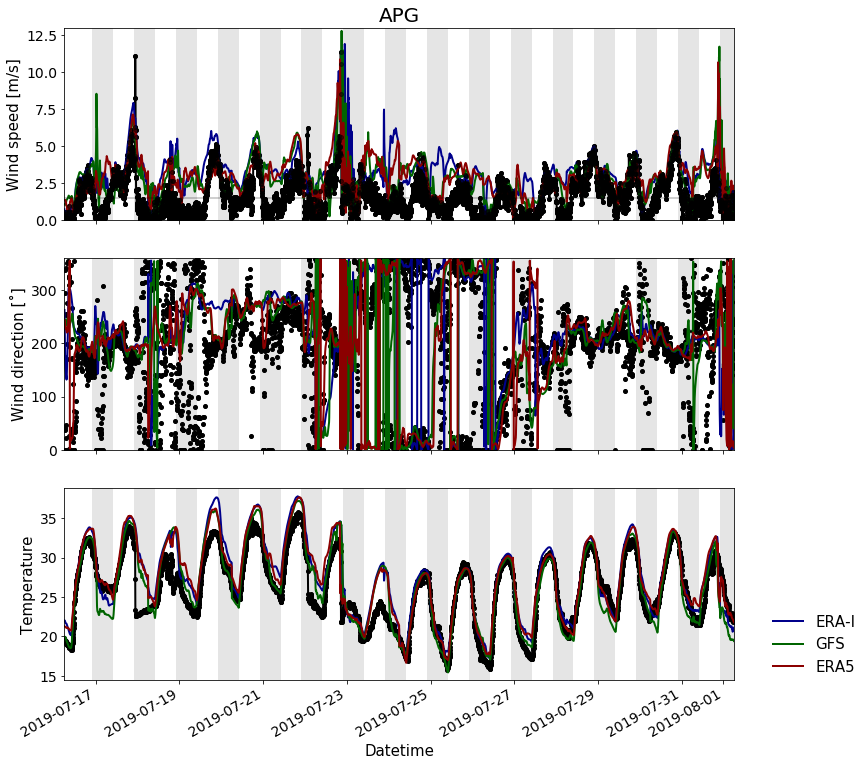

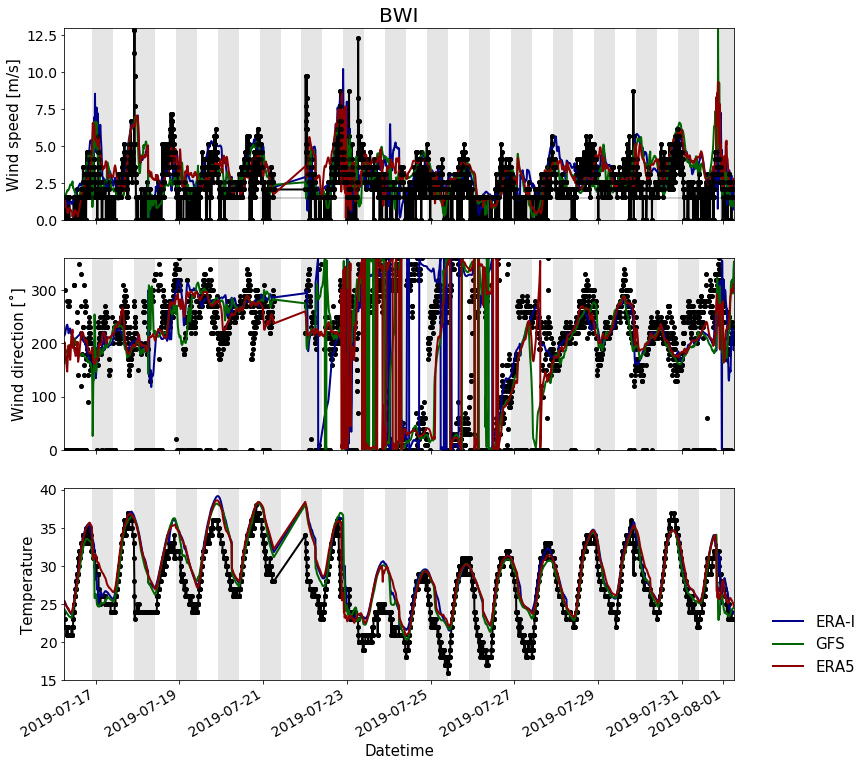

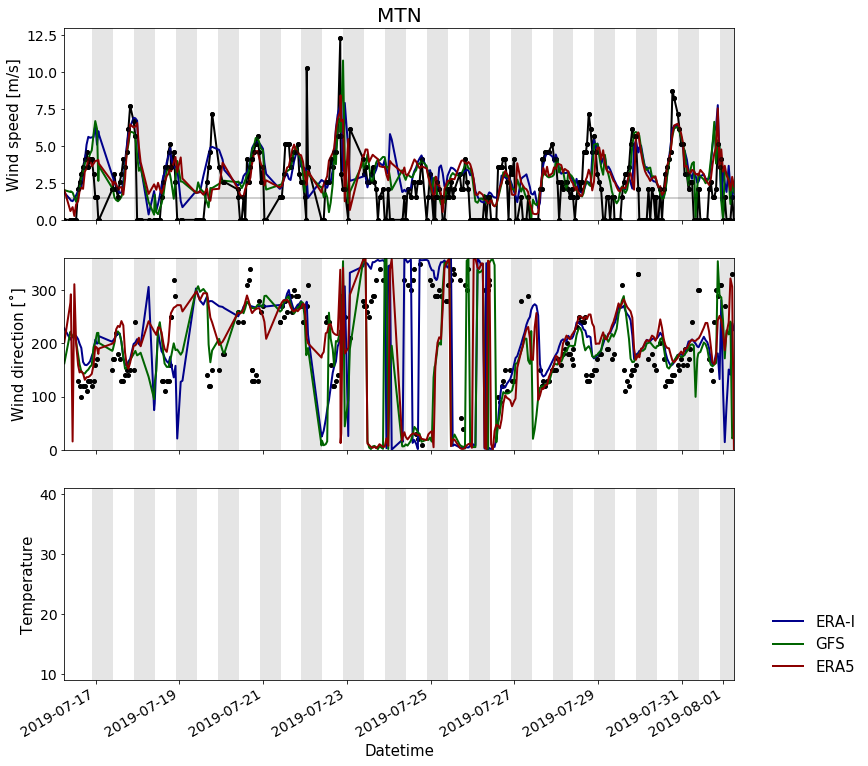

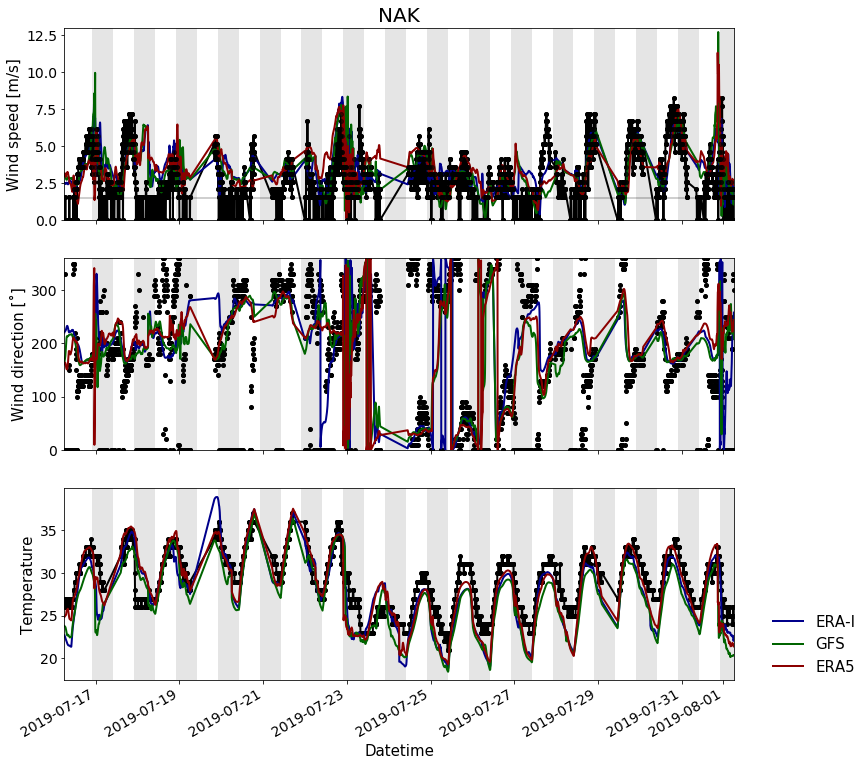

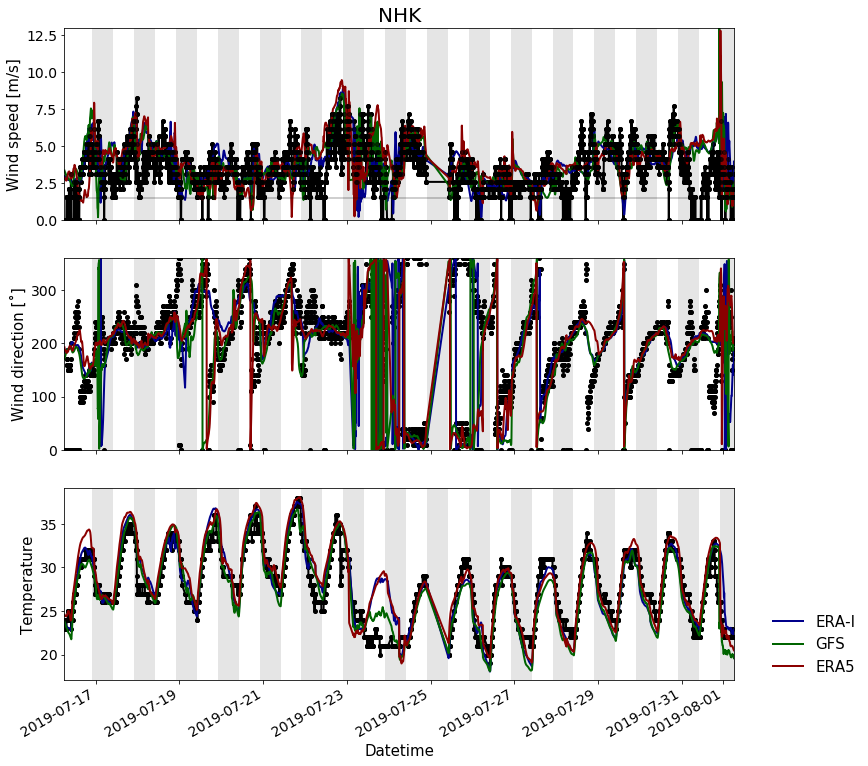

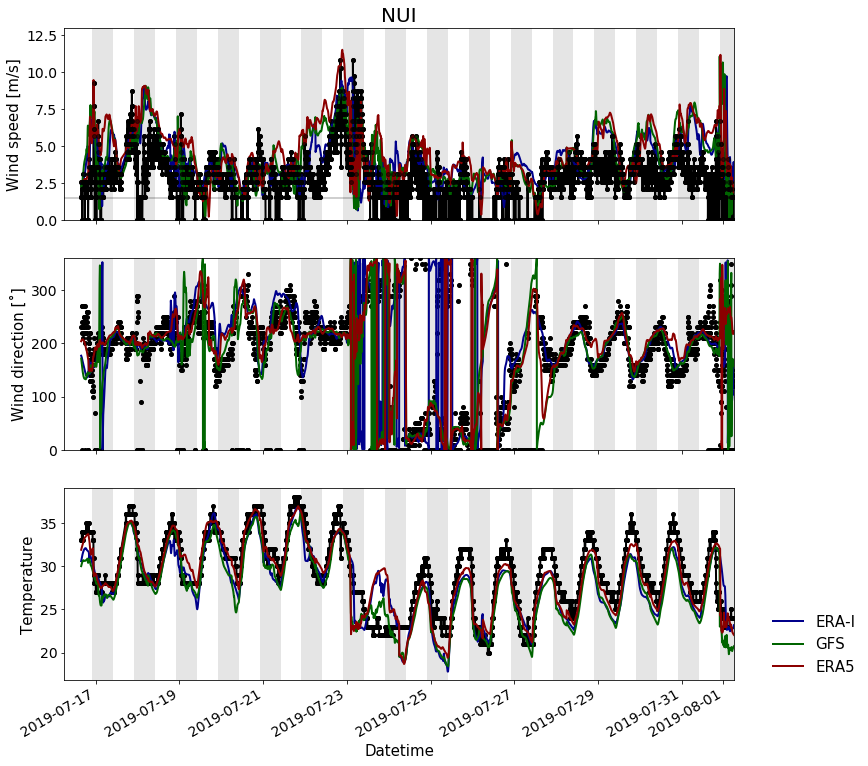

In [30]:
wlvl = 0 # Roughly 10 m
for ss,stn in enumerate(near_shore_stations):
    fig,ax = plt.subplots(nrows=3,figsize=(12,12),sharex=True)
    obs_ds = obs_res_full.sel(station=stn)

    wspd_obs = obs_ds.wspd.dropna(how='all',dim='datetime')
    if len(wspd_obs) > 1:
        wspd_obs.plot(ax=ax[0],lw=0.0,c='k',marker='o',markersize=4,zorder=3,alpha=0.5)
        wspd_obs.plot(ax=ax[0],lw=2.0,c='k',marker='o',markersize=4)
    wdir_obs = obs_ds.wdir.dropna(how='all',dim='datetime')
    if len(wdir_obs) > 1:
        wdir_obs.plot(ax=ax[1],lw=0.0,c='k',marker='o',markersize=4)
    temp_obs = obs_ds.temp.dropna(how='all',dim='datetime')
    if len(temp_obs) > 1:
        temp_obs.plot(ax=ax[2],lw=2.0,c='k',marker='o',markersize=4)
        max_t = np.nanmax(temp_obs)
        min_t = np.nanmin(temp_obs)
    else:
        max_t = 40
        min_t = 10
    
    for cc,case in enumerate(cases_of_interest):
        twr_ds = wrf_twrs_res['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))]
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

        stn_ds = twr_ds.sel(station=stn)
        #levels = stn_ds.ph.data[0,:,0]

        # ============================================= #
        # ============= WIND SPEED PLOT =============== #
        wspd_wrf = stn_ds.wspd10.dropna(how='all',dim='datetime')
        if len(wspd_wrf) > 1:
            wspd_wrf.plot(ax=ax[0],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])
        
        

        # ============================================= #
        # =============  WIND DIR PLOT  =============== #
        wdir_wrf = stn_ds.wdir10.dropna(how='all',dim='datetime')
        if len(wdir_wrf) > 1:
            wdir_wrf.plot(ax=ax[1],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])
        

        # ============================================= #
        # ============ TEMPERATURE PLOT =============== #
        temp_wrf = stn_ds.t2.dropna(how='all',dim='datetime')
        if len(temp_wrf) > 1:
            temp_wrf.plot(ax=ax[2],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])
        
            max_t0 = np.nanmax(temp_wrf)
            min_t0 = np.nanmin(temp_wrf)
        else:
            stn_ds.t2.plot(ax=ax[2],label='{}'.format(case_plt_dict['name']),
                          c=case_plt_dict['color'],lw=2.0)#,ls=case_style[cc])

        if max_t0 > max_t: max_t = max_t0
        if min_t0 < min_t: min_t = min_t0
    try:
        if np.nanmax(temp_obs) > max_t: max_t = np.nanmax(temp_obs)
    except:
        max_t = max_t
    # --------- Wind Speed Adjustments ---------- #
    plt_start_date = pd.to_datetime(obs_ds.datetime.values[0])
    plt_end_date = pd.to_datetime(obs_ds.datetime.values[-1])
    for day in pd.date_range(start=plt_start_date, end=plt_end_date):
        night_s = pd.to_datetime('{}-{}-{} 22:00'.format(day.year,day.month,day.day))
        night_e = pd.to_datetime('{}-{}-{} 10:00'.format(day.year,day.month,day.day)) + pd.Timedelta(1,'d')
        for axi in range(0,3):
            #print('start: {}, end: {}'.format(night_s,night_e))
            ax[axi].fill_betweenx([0,400],night_s,night_e,facecolor='k',alpha=0.1)
    ax[2].legend(frameon=False,fontsize=15,loc=[1.05,0.0],ncol=1)
      
    ax[0].axhline(1.5,0,13,c='k',alpha=0.25)
    ax[0].set_title(stn,size=20)
    ax[0].set_xlabel('')
    ax[0].tick_params(labelsize=14)
    ax[0].set_ylabel('Wind speed [m/s]',size=15)
    ax[0].set_ylim(0,13)
    ax[0].set_xlim(t_s,t_e)
    leg_loc = 0.89

    # --------- Wind Direction Adjustments --------- #
    ax[1].set_ylim(0,360)
    ax[1].set_xlabel('')
    ax[1].set_title('')
    ax[1].tick_params(labelsize=14)
    ax[1].set_ylabel('Wind direction [˚]',size=15)

    # --------- Temperature Adjustments --------- #
    #ax[2].set_ylim(0,360)
    ax[2].set_title('')
    ax[2].tick_params(labelsize=14)
    ax[2].set_ylabel('Temperature',size=15)
    ax[2].set_xlabel('Datetime',size=15)
    ax[2].set_ylim(min_t-1.0,max_t+1.0)
    # -------------------------------------------- #
    plt.show()
    


### Check Skin Temp differences for SST change

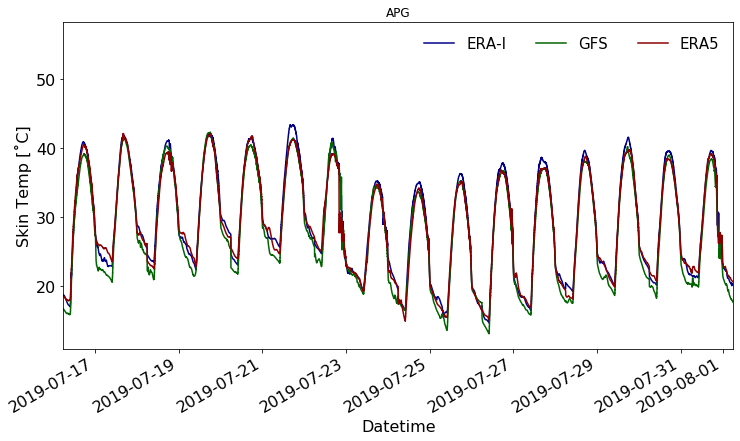

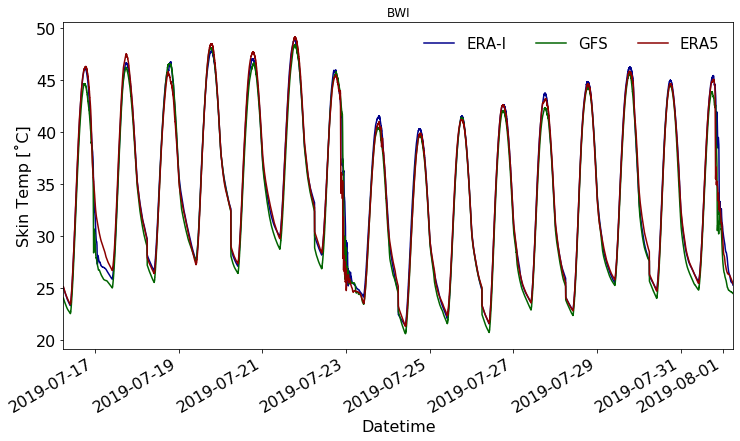

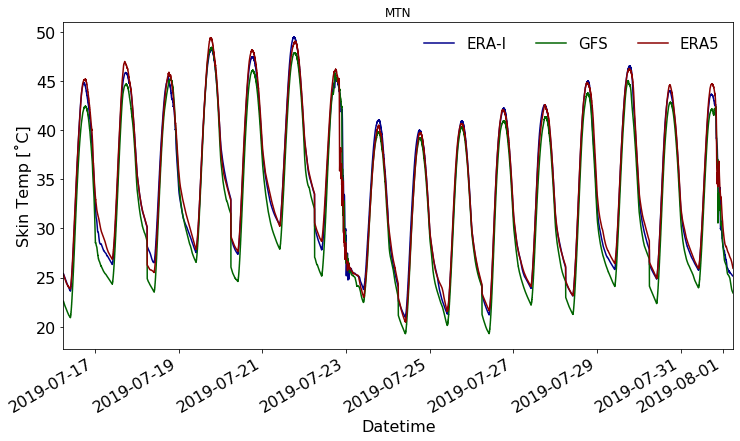

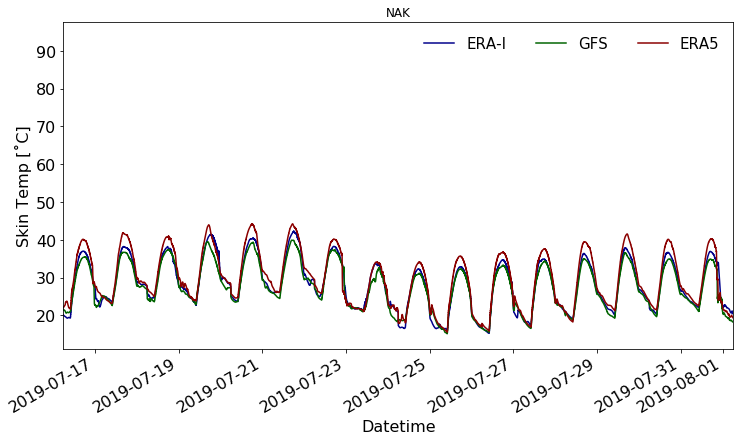

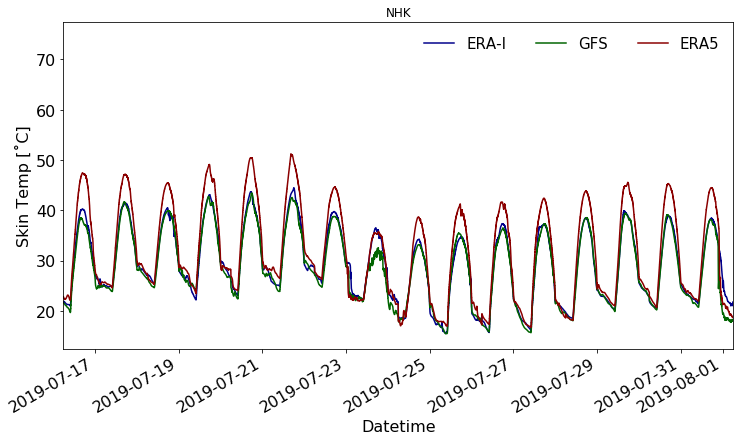

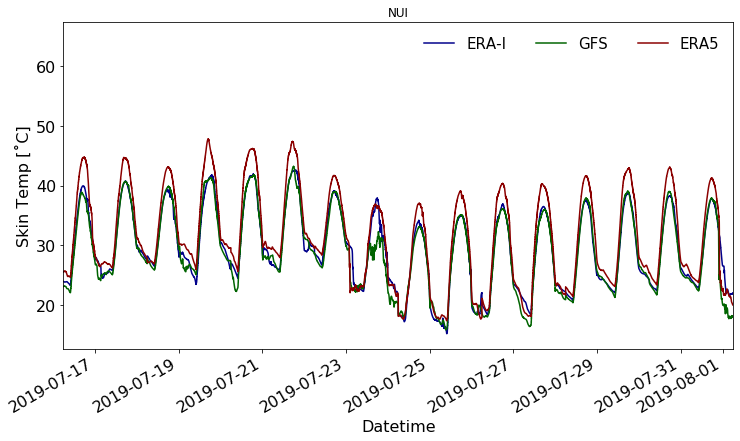

In [31]:
twr_st = ['-',':','-','-','-']
for ss,stn in enumerate(near_shore_stations):
    plt.figure(figsize=(12,6))
    for cc,case in enumerate(cases_of_interest):
        twr_ds = wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))].sel(station=stn)
        case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]

        (twr_ds.tsk-273.15).plot(label='{}'.format(case_plt_dict['name']),c=case_plt_dict['color'])#,ls=twr_st[cc])
    plt.legend(frameon=False,fontsize=15,ncol=3,loc=1)
    plt.title(stn)
    plt.tick_params(labelsize=16)
    plt.ylabel('Skin Temp [˚C]',size=16)
    plt.xlabel('Datetime',size=16)
    plt.xlim(t_s,t_e)
    plt.show()

# 2-D Histograms

In [27]:
def create_2dHistogram(varA,varB,n_binsA,n_binsB):
    '''
    Returns the x, y, and z arrays to plot a 2-D histogram
    given two variables, A (x-axis) and B (y-axis).
    To call:
    x,y,z = create_2dHistogram(variableA,variableB,number_of_bins)
    To plot, call:
    plt.pcolormesh(x,y, z,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
    '''
    varA_flat = varA.flatten()
    varB_flat = varB.flatten()
    varA_vs_varB, ab_xedges, ab_yedges = np.histogram2d(varA_flat, varB_flat, bins=[n_binsA,n_binsB])
    x_2d, y_2d = np.meshgrid(ab_xedges,ab_yedges)
    return(x_2d,y_2d,varA_vs_varB.T)

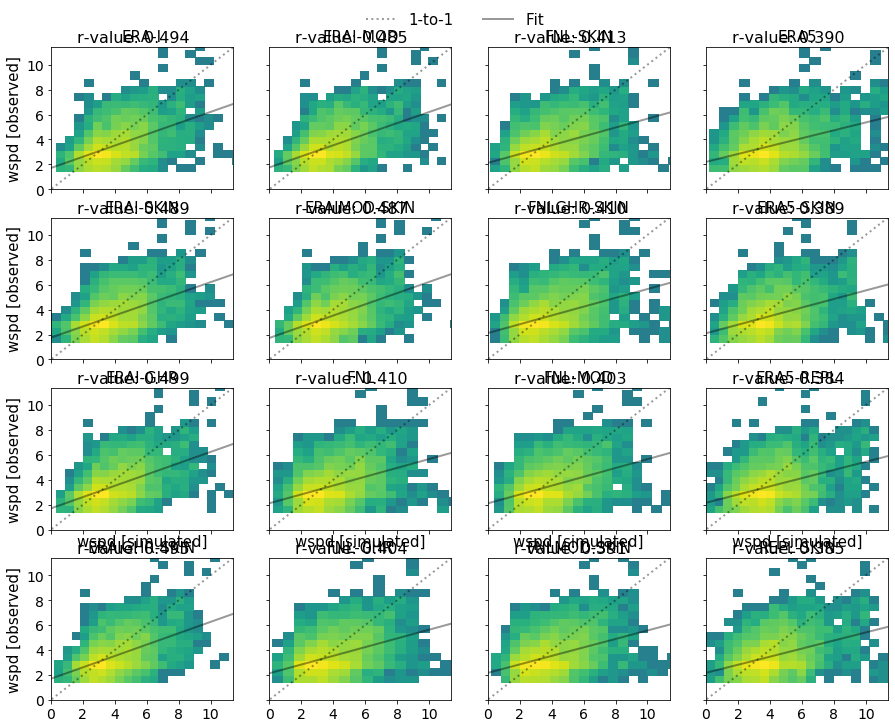

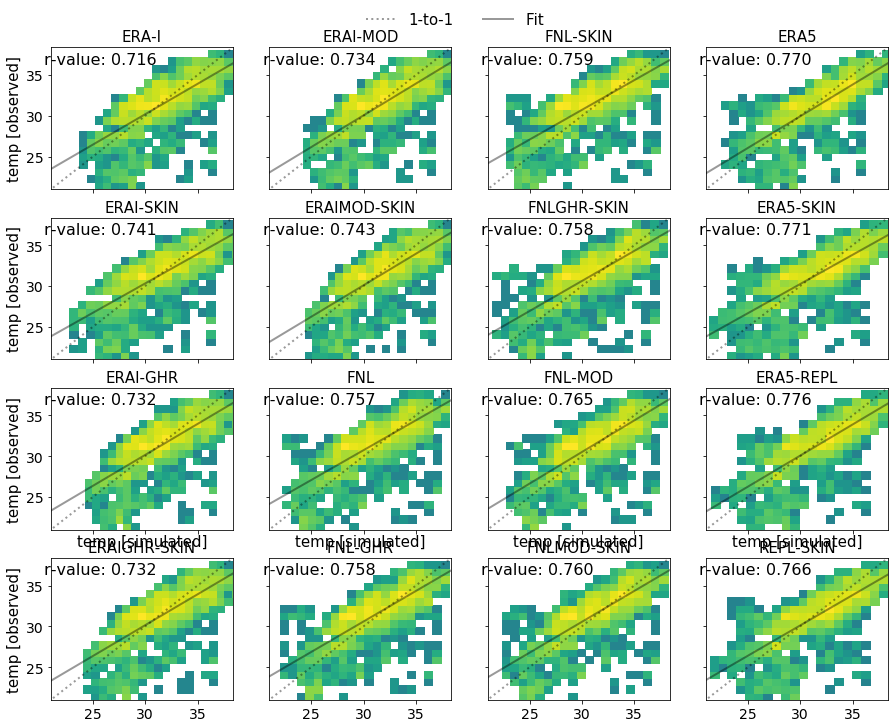

In [32]:
for var in TD_vars:
    obs_var = var
    sim_var = vars_to_compare[var]
    fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(15,12),sharey=True,sharex=True)
    row = 0
    col = 0
    for cc,case in enumerate(cases_of_interest):
        for ss,stn in enumerate(TD_stns):
            if stn == 'GRF':# and var == 'sst':
                print('skipping {} for GRF'.format(var))
                varA = []
                varB = []
            else:
                obs = TD_obs_full[stn][obs_var]
                obs = obs.dropna(how='any',dim='datetime')

                case_plt_dict = case_dict[case]['d0{}'.format(doms_of_interest[cc])]
                sim = TD_wrf_twrs['{}_{}'.format(case,'d0{}'.format(doms_of_interest[cc]))][sim_var].sel(station=stn)
                sim = sim.dropna(how='any',dim='datetime')

                varA = sim.data
                varB = obs.data
            
            if ss == 0:
                varA_f = varA
                varB_f = varB
            else:
                varA_f = np.concatenate((varA_f,varA))
                varB_f = np.concatenate((varB_f,varB))
        if (len(varA_f) == len(varB_f)) and (len(varA_f) > 2):
            slope, intercept, r_value, p_value, std_err = stats.linregress(varA_f, varB_f)
            x2d,y2d,hist2d = create_2dHistogram(varA_f,varB_f,20,20)

            ax[row,col].pcolormesh(x2d,y2d, hist2d,norm=colors.LogNorm(vmin=1e-2,vmax=hist2d.max()))
            #plt.colorbar()
            if col == 0: ax[row,col].set_ylabel('{} [observed]'.format(var),size=15)
            if row == 2: ax[row,col].set_xlabel('{} [simulated]'.format(var),size=15)
            ref_x = np.arange(-1000,1001)
            if cc == 0:
                line_lbl1 = '1-to-1'
                line_lbl2 = 'Fit'
            else:
                line_lbl1 = None
                line_lbl2 = None
            ax[row,col].plot(ref_x,ref_x,c='k',lw=2.0,alpha=0.4,ls=':',label=line_lbl1)
            ax[row,col].plot(ref_x,slope*ref_x + intercept,c='k',lw=2.0,alpha=0.4,label=line_lbl2)
            if cc == 0: ax[0,0].legend(frameon=False,loc=(1.7,1.1),fontsize=15,ncol=2)

            if var == 'sst':
                tick_min,tick_max,tick_int = 24,32,2
            elif var == 'temp':
                tick_min,tick_max,tick_int = 20,35,5
            elif var == 'wspd':
                tick_min,tick_max,tick_int = 0,20,2
            elif var == 'wdir':
                tick_min,tick_max,tick_int = 0,360,90
            elif var == 'u' or var == 'v':
                tick_min,tick_max,tick_int = -5,5,5
                
            xmin,xmax = (np.floor(np.nanmin(x2d)),np.nanmax(x2d))
            ymin,ymax = (np.nanmin(y2d),np.nanmax(y2d))
            if var == 'wdir':
                ymin,ymax = 0,360
            ax[row,col].set_xticks(np.arange(tick_min,tick_max+1,tick_int))
            ax[row,col].set_yticks(np.arange(tick_min,tick_max+1,tick_int))
            ax[row,col].set_xlim(xmin,xmax)
            ax[row,col].set_ylim(xmin,xmax)
            ax[row,col].text(ymin+0.02*(ymax-ymin),ymin+0.99*(ymax-ymin),'r-value: {0:4.3f}'.format(r_value),size=16,va='top')
            ax[row,col].set_title(case_plt_dict['name'],size=15)
            ax[row,col].tick_params(labelsize=14)
            row += 1
            if row == 4:
                row = 0
                col += 1
    plt.show()
    print()
    print()
    
                
        